In [14]:
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp, ttest_ind, epps_singleton_2samp
from itertools import groupby
import matplotlib.pyplot as plt

In [2]:
!which python

/usr/licensed/anaconda3/2021.11/bin/python


In [3]:
def get_member_ratio(datadf, metrics, thre_cnt=1, skip=[], mode='ks'):
    sample2mem = []
    for idx, row in datadf.iterrows():
        sample2mem.append(np.sum([row[m] for m in (set(metrics) - set(skip))]))
    
    members_bool = np.asarray(sample2mem) >= thre_cnt

    if mode == 'ks': # ks distance
        _, pvalue = ks_2samp(members_bool,[1 for i in range(10000)] , mode='asymp')
    elif mode == 't': # all
        if members_bool.mean() == 1:
            return 1, 1
        else:
            _, pvalue = ttest_ind(members_bool,[1 for i in range(len(members_bool))], equal_var = True, nan_policy='raise')
    elif mode == 'epps': # all
        if members_bool.mean() == 1:
            return 1, 1
        else:
            _, pvalue = ttest_ind(members_bool,[1 for i in range(len(members_bool))], equal_var = False, nan_policy='raise')
    elif mode == 'majority':
        if members_bool.sum() > members_bool.size // 2:
            return 1, 1
        else:
            return 0, 0

    return np.sum(members_bool) / len(datadf), pvalue

In [4]:
!pwd

/scratch/gpfs/aalag/DataAuditingThesis


In [5]:
class TableObj:
    def __init__(self, table, expt, mode, size, data, metrics):
        self.table = table
        self.expt = expt
        self.mode = mode
        self.size = size
        self.data = data
        self.metrics = metrics

In [6]:
def compute_tables(experiments, data, sizes, modes, epoch, metrics, klist, mixup, cutoff=False):
    tables = []
    if data == ['MNIST']:
        cols = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'SVHN']
    elif data == ['Location']:
        cols = ['L1', 'L2', 'L3', 'L4', 'L5', 'L6']
    elif data == ['COVIDx']:
        cols = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'Chest']
    
    EMA_res_table = pd.DataFrame(columns=cols, index=[f'k={100-k}' for k in klist])
    for i, expt in enumerate(experiments):
        for caldata in data:
            for size in sizes:
                for mode in modes:
                    print(f'-----  Query_size:{size} \t Cal data:{caldata}  -----')
                    for k in klist:
                        logname = f'caldata={caldata}_epoch={epoch}_k={k}_calsize=10000'
                        for fold in range(7):
                            if caldata == 'Location' and fold == 0:
                                continue
                            queryset = pd.read_csv(f'./saves_new/{expt}/EMA_{caldata}/query_set/binarized_{logname}_fold{fold}.csv') 
                            if fold == 0 or fold == 6:
                                ground_truth = 'Query is not in base'
                            else:
                                ground_truth = 'Query is in base'
                                
                            t, pv = get_member_ratio(queryset[:size], metrics, mode=mode)

                            EMA_res = np.around(pv, decimals=2)
                            if fold == 0 and caldata == 'MNIST':
                                EMA_res_table['SVHN'][f'k={100-k}'] = EMA_res
                            elif fold == 0 and caldata == 'COVIDx':
                                EMA_res_table['Chest'][f'k={100-k}'] = EMA_res
                            elif caldata == 'Location':
                                EMA_res_table[f'L{fold}'][f'k={100-k}'] = EMA_res
                            elif caldata == 'MNIST':
                                EMA_res_table[f'M{fold}'][f'k={100-k}'] = EMA_res
                            elif caldata == 'COVIDx':
                                EMA_res_table[f'C{fold}'][f'k={100-k}'] = EMA_res

                    if expt == "":
                        table_obj = TableObj(EMA_res_table, "Control EMA", mode, size, caldata, metrics)
                    else:
                        table_obj = TableObj(EMA_res_table, expt, mode, size, caldata, metrics)
                    tables.append(table_obj)
                    print(EMA_res_table, '\n')
                    
                    EMA_res_table = pd.DataFrame(columns=cols, index=[f'k={100-k}' for k in klist])

    return tables

In [24]:
### Run EMA on the benchmark datasets, Table 2.b and Table 6
# experiments = ["", "re-dropout0.1", "re-dropout0.2", "re-dropout0.3", "re-dropout0.4", "re-dropout0.5", "re-dropout0.6","re-dropout0.7","re-dropout0.8", "re-dropout0.9", "re-plateau1"]
# experiments = ["LocDropout0.0", "LocDropout0.1", "LocDropout0.2", "LocDropout0.3", "LocDropout0.4", "LocDropout0.5", "LocDropout0.6", "LocDropout0.7", "LocDropout0.8", "LocDropout0.9"]
# experiments = ["LocDropout0.0", "MemGuard_mixup", "MemGuard_noMixup"]
# experiments = ["Location_base", "Location_sparsity0.1", "Location_sparsity0.2", "Location_sparsity0.3",
#               "Location_sparsity0.4", "Location_sparsity0.5", "Location_sparsity0.6", "Location_sparsity0.7",
#                "Location_sparsity0.8", "Location_sparsity0.9"]
# experiments = ["Location_base", "Location_sparsity0.65", "Location_sparsity0.725", "Location_sparsity0.75", "Location_sparsity0.775"]
# experiments = ["MNIST_base", "MNIST_sparsity0.625", "MNIST_sparsity0.65", "MNIST_sparsity0.675"]
# experiments = ["Location_base_redo", "LocDropout0.1_redo", "LocDropout0.2_redo", "LocDropout0.3_redo",
#               "LocDropout0.4_redo", "LocDropout0.5_redo", "LocDropout0.6_redo", "LocDropout0.7_redo",
#               "LocDropout0.8_redo", "LocDropout0.9_redo"]
# experiments = ["MNIST_base_50", "dropout0.1_redo", "dropout0.2_redo", "dropout0.3_redo", "dropout0.4_redo",
#               "dropout0.5_redo", "dropout0.6_redo", "dropout0.7_redo", "dropout0.8_redo", "dropout0.9_redo"]

drop_size = ["MNIST_sparsity0.5_redo", "dropout0.5_redo"]

# experiments = ["MNIST_base_50", "MNIST_sparsity0.1_redo", "MNIST_sparsity0.2_redo", "MNIST_sparsity0.3_redo",
#                "MNIST_sparsity0.4_redo", "MNIST_sparsity0.5_redo", "MNIST_sparsity0.625_redo", "MNIST_sparsity0.65_redo",
#               "MNIST_sparsity0.675_redo", "MNIST_sparsity0.6_redo", "MNIST_sparsity0.7_redo", "MNIST_sparsity0.8_redo",
#               "MNIST_sparsity0.9_redo"]

# experiments = ["Location_base_redo", "Location_sparsity0.1_redo", "Location_sparsity0.2_redo", "Location_sparsity0.3_redo",
#               "Location_sparsity0.4_redo", "Location_sparsity0.5_redo", "Location_sparsity0.6_redo",
#                "Location_sparsity0.65_redo", "Location_sparsity0.7_redo", "Location_sparsity0.725_redo", "Location_sparsity0.75_redo",
#               "Location_sparsity0.775_redo", "Location_sparsity0.8_redo", "Location_sparsity0.9_redo"]

# experiments = ["MNIST_base_50", "plateau10_redo", "plateau1_redo", "plateau20_redo", "plateau5_redo"]
# experiments = ["MNIST_base_redo", "MNIST_base_50"]
# experiments = ["Location_base_redo", "MemGuard_mixup_redo", "MemGuard_noMixup_redo"]
# covid_sparsity = ["COVIDx_base", "COVIDx_sparsity0.1", "COVIDx_sparsity0.2", "COVIDx_sparsity0.3",
#               "COVIDx_sparsity0.4", "COVIDx_sparsity0.5", "COVIDx_sparsity0.6", "COVIDx_sparsity0.7",
#               "COVIDx_sparsity0.8", "COVIDx_sparsity0.9"]

lenet_drop = ["MNIST_base_50", "Lenet_MNIST", "Lenet_MNIST0.1", "Lenet_MNIST0.2",
              "Lenet_MNIST0.3", "Lenet_MNIST0.4", "Lenet_MNIST0.5", "Lenet_MNIST0.6",
              "Lenet_MNIST0.7", "Lenet_MNIST0.8", "Lenet_MNIST0.9"]

lenet_sparse = ["Lenet_MNIST", "Lenet_sparsity0.1", "Lenet_sparsity0.2", "Lenet_sparsity0.3",
              "Lenet_sparsity0.4", "Lenet_sparsity0.5", "Lenet_sparsity0.6",
              "Lenet_sparsity0.7", "Lenet_sparsity0.8", "Lenet_sparsity0.9"]

# experiments = ["COVIDx_base", "COVIDx_dropout0.0", "COVIDx_dropout0.1", "COVIDx_dropout0.2",
#               "COVIDx_dropout0.3", "COVIDx_dropout0.4", "COVIDx_dropout0.5", "COVIDx_dropout0.6",
#               "COVIDx_dropout0.7", "COVIDx_dropout0.8", "COVIDx_dropout0.9"]

gan = ["Lenet_MNIST", "MNIST_GAN20", "MNIST_GAN100", "MNIST_GAN1000", "MNIST_GAN2000", "MNIST_GAN5000", "MNIST_GAN10000", "MNIST_GAN20000",
              "MNIST_GAN50000", "MNIST_GAN60000"]

# covid_base = ["COVIDx_base"]
mnist_base = ["MNIST_base_50"]
# location_base = ["Location_base_redo"]

small_mnist = ["MNIST_base_50", "SmallMNIST0.0", "SmallMNIST0.1", "SmallMNIST0.2", "SmallMNIST0.3",
              "SmallMNIST0.4", "SmallMNIST0.5", "SmallMNIST0.6", "SmallMNIST0.7", "SmallMNIST0.8",
              "SmallMNIST0.9"]

covgan = ["COVIDx_finalGAN20", "COVIDx_finalGAN100", "COVIDx_finalGAN200", "COVIDx_finalGAN500", "COVIDx_finalGAN1000", "COVIDx_finalGAN2000", "COVIDx_finalGAN3000", "COVIDx_finalGAN4000"]
covgan2 = ["COVIDx_finalGAN100_seed", "COVIDx_finalGAN200_seed", "COVIDx_finalGAN500_seed", "COVIDx_finalGAN1000_seed", "COVIDx_finalGAN2000_seed", "COVIDx_finalGAN3000_seed", "COVIDx_finalGAN4000_seed"]

all_cov_tables = ["COVIDx_finalGAN100", "COVIDx_finalGAN1000",
                 "COVIDx_finalGAN100_seed", "COVIDx_finalGAN100_seed10", "COVIDx_finalGAN100_seed100",
                 "COVIDx_finalGAN1000_seed", "COVIDx_finalGAN1000_seed10", "COVIDx_finalGAN1000_seed100",
                 "COVIDx_finalGAN20", "COVIDx_finalGAN200", "COVIDx_finalGAN2000", "COVIDx_finalGAN2000_seed",
                 "COVIDx_finalGAN2000_seed10", "COVIDx_finalGAN2000_seed100", "COVIDx_finalGAN200_seed",
                 "COVIDx_finalGAN200_seed10", "COVIDx_finalGAN200_seed100", "COVIDx_finalGAN3000",
                 "COVIDx_finalGAN3000_seed", "COVIDx_finalGAN3000_seed10", "COVIDx_finalGAN3000_seed100",
                 "COVIDx_finalGAN4000", "COVIDx_finalGAN4000_seed", "COVIDx_finalGAN4000_seed10",
                 "COVIDx_finalGAN4000_seed100", "COVIDx_finalGAN500", "COVIDx_finalGAN500_seed",
                 "COVIDx_finalGAN500_seed10", "COVIDx_finalGAN500_seed100", "COVIDx_noisyGAN4000",
                 "COVIDx_finalGAN20_seed1", "COVIDx_finalGAN20_seed10", "COVIDx_finalGAN20_seed100",
                 "COVIDx_noisyGAN_seed1", "COVIDx_noisyGAN_seed10", "COVIDx_noisyGAN_seed100"]
epoch = 50
# epoch = 200

# epochs = [200, 50]
# epochs = [50, 50, 50, 50, 50, 50, 50, 50, 50, 50]

metrics = ['correctness', 'confidence', 'entropy', 'modified entropy', 'scaled logits']

klist = [0, 10, 20, 30, 40, 50]
sizes = [2000, 500, 200, 50, 20, 5]
# data = ['MNIST']
# data = ['Location']
data = ['COVIDx']
mixup = False
modes = ['t']

In [25]:
metric_list = [['correctness', 'confidence', 'entropy'], ['correctness'], ['confidence'], ['entropy'], ['modified entropy'], ['scaled logits'], ['correctness', 'confidence', 'entropy', 'modified entropy', 'scaled logits'], ['correctness', 'confidence'], ['correctness', 'entropy'], ['correctness', 'modified entropy'], ['correctness', 'scaled logits'], ['correctness', 'confidence', 'scaled logits', 'modified entropy']]

In [26]:
covgan_tables = compute_tables(all_cov_tables, data, sizes, modes, epoch, metrics, klist, mixup)

-----  Query_size:2000 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5   C6 Chest
k=100  1  1  1  1  1  0.0   0.0
k=90   1  1  1  1  1  0.0   0.0
k=80   1  1  1  1  1  0.0   0.0
k=70   1  1  1  1  1  0.0   0.0
k=60   1  1  1  1  1  0.0   0.0
k=50   1  1  1  1  1  0.0   0.0 

-----  Query_size:500 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5   C6 Chest
k=100  1  1  1  1  1  0.0   0.0
k=90   1  1  1  1  1  0.0   0.0
k=80   1  1  1  1  1  0.0   0.0
k=70   1  1  1  1  1  0.0   0.0
k=60   1  1  1  1  1  0.0   0.0
k=50   1  1  1  1  1  0.0   0.0 

-----  Query_size:200 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5    C6 Chest
k=100  1  1  1  1  1   0.0   0.0
k=90   1  1  1  1  1   0.0   0.0
k=80   1  1  1  1  1   0.0   0.0
k=70   1  1  1  1  1   0.0   0.0
k=60   1  1  1  1  1  0.01   0.0
k=50   1  1  1  1  1   0.0   0.0 

-----  Query_size:50 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5    C6 Chest
k=100  1  1  1  1  1  0.16   0.0
k=90   1  1  1  1  1  0.04   0.0
k=80   1  1  1  1  1  0.16  

      C1 C2 C3 C4 C5   C6 Chest
k=100  1  1  1  1  1  0.0   0.0
k=90   1  1  1  1  1  0.0   0.0
k=80   1  1  1  1  1  0.0   0.0
k=70   1  1  1  1  1  0.0   0.0
k=60   1  1  1  1  1  0.0   0.0
k=50   1  1  1  1  1  0.0   0.0 

-----  Query_size:500 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5   C6 Chest
k=100  1  1  1  1  1  0.0   0.0
k=90   1  1  1  1  1  0.0   0.0
k=80   1  1  1  1  1  0.0   0.0
k=70   1  1  1  1  1  0.0   0.0
k=60   1  1  1  1  1  0.0   0.0
k=50   1  1  1  1  1  0.0   0.0 

-----  Query_size:200 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5   C6 Chest
k=100  1  1  1  1  1  0.0   0.0
k=90   1  1  1  1  1  0.0   0.0
k=80   1  1  1  1  1  0.0   0.0
k=70   1  1  1  1  1  0.0   0.0
k=60   1  1  1  1  1  0.0   0.0
k=50   1  1  1  1  1  0.0   0.0 

-----  Query_size:50 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5    C6 Chest
k=100  1  1  1  1  1  0.16  0.02
k=90   1  1  1  1  1  0.16   0.0
k=80   1  1  1  1  1  0.16   0.0
k=70   1  1  1  1  1  0.16   0.0
k=60   1  1  1  1

      C1 C2 C3 C4 C5   C6 Chest
k=100  1  1  1  1  1  0.0   0.0
k=90   1  1  1  1  1  0.0   0.0
k=80   1  1  1  1  1  0.0   0.0
k=70   1  1  1  1  1  0.0   0.0
k=60   1  1  1  1  1  0.0   0.0
k=50   1  1  1  1  1  0.0   0.0 

-----  Query_size:500 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5   C6 Chest
k=100  1  1  1  1  1  0.0   0.0
k=90   1  1  1  1  1  0.0   0.0
k=80   1  1  1  1  1  0.0   0.0
k=70   1  1  1  1  1  0.0   0.0
k=60   1  1  1  1  1  0.0   0.0
k=50   1  1  1  1  1  0.0   0.0 

-----  Query_size:200 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5   C6 Chest
k=100  1  1  1  1  1  0.0   0.0
k=90   1  1  1  1  1  0.0   0.0
k=80   1  1  1  1  1  0.0   0.0
k=70   1  1  1  1  1  0.0   0.0
k=60   1  1  1  1  1  0.0   0.0
k=50   1  1  1  1  1  0.0   0.0 

-----  Query_size:50 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5    C6 Chest
k=100  1  1  1  1  1  0.32   0.0
k=90   1  1  1  1  1  0.04   0.0
k=80   1  1  1  1  1  0.02  0.02
k=70   1  1  1  1  1  0.04  0.01
k=60   1  1  1  1

      C1 C2 C3 C4 C5   C6 Chest
k=100  1  1  1  1  1  0.0   0.0
k=90   1  1  1  1  1  0.0   0.0
k=80   1  1  1  1  1  0.0   0.0
k=70   1  1  1  1  1  0.0   0.0
k=60   1  1  1  1  1  0.0   0.0
k=50   1  1  1  1  1  0.0   0.0 

-----  Query_size:500 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5   C6 Chest
k=100  1  1  1  1  1  0.0   0.0
k=90   1  1  1  1  1  0.0   0.0
k=80   1  1  1  1  1  0.0   0.0
k=70   1  1  1  1  1  0.0   0.0
k=60   1  1  1  1  1  0.0   0.0
k=50   1  1  1  1  1  0.0   0.0 

-----  Query_size:200 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5   C6 Chest
k=100  1  1  1  1  1  0.0   0.0
k=90   1  1  1  1  1  0.0   0.0
k=80   1  1  1  1  1  0.0   0.0
k=70   1  1  1  1  1  0.0   0.0
k=60   1  1  1  1  1  0.0   0.0
k=50   1  1  1  1  1  0.0   0.0 

-----  Query_size:50 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5    C6 Chest
k=100  1  1  1  1  1  0.16   0.0
k=90   1  1  1  1  1  0.16   0.0
k=80   1  1  1  1  1  0.16   0.0
k=70   1  1  1  1  1  0.16   0.0
k=60   1  1  1  1

      C1 C2 C3 C4 C5   C6 Chest
k=100  1  1  1  1  1  0.0   0.0
k=90   1  1  1  1  1  0.0   0.0
k=80   1  1  1  1  1  0.0   0.0
k=70   1  1  1  1  1  0.0   0.0
k=60   1  1  1  1  1  0.0   0.0
k=50   1  1  1  1  1  0.0   0.0 

-----  Query_size:500 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5   C6 Chest
k=100  1  1  1  1  1  0.0   0.0
k=90   1  1  1  1  1  0.0   0.0
k=80   1  1  1  1  1  0.0   0.0
k=70   1  1  1  1  1  0.0   0.0
k=60   1  1  1  1  1  0.0   0.0
k=50   1  1  1  1  1  0.0   0.0 

-----  Query_size:200 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5   C6 Chest
k=100  1  1  1  1  1  0.0   0.0
k=90   1  1  1  1  1  0.0   0.0
k=80   1  1  1  1  1  0.0   0.0
k=70   1  1  1  1  1  0.0   0.0
k=60   1  1  1  1  1  0.0   0.0
k=50   1  1  1  1  1  0.0   0.0 

-----  Query_size:50 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5    C6 Chest
k=100  1  1  1  1  1  0.08   0.0
k=90   1  1  1  1  1  0.08   0.0
k=80   1  1  1  1  1  0.08   0.0
k=70   1  1  1  1  1  0.08   0.0
k=60   1  1  1  1

      C1 C2 C3 C4 C5   C6 Chest
k=100  1  1  1  1  1    1     1
k=90   1  1  1  1  1  0.0   0.0
k=80   1  1  1  1  1  0.0   0.0
k=70   1  1  1  1  1  0.0   0.0
k=60   1  1  1  1  1  0.0   0.0
k=50   1  1  1  1  1  0.0   0.0 

-----  Query_size:500 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5   C6 Chest
k=100  1  1  1  1  1    1     1
k=90   1  1  1  1  1  0.0   0.0
k=80   1  1  1  1  1  0.0   0.0
k=70   1  1  1  1  1  0.0   0.0
k=60   1  1  1  1  1  0.0   0.0
k=50   1  1  1  1  1  0.0   0.0 

-----  Query_size:200 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5   C6 Chest
k=100  1  1  1  1  1    1     1
k=90   1  1  1  1  1  0.0   0.0
k=80   1  1  1  1  1  0.0   0.0
k=70   1  1  1  1  1  0.0   0.0
k=60   1  1  1  1  1  0.0   0.0
k=50   1  1  1  1  1  0.0   0.0 

-----  Query_size:50 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5    C6 Chest
k=100  1  1  1  1  1     1     1
k=90   1  1  1  1  1  0.08   0.0
k=80   1  1  1  1  1  0.08  0.04
k=70   1  1  1  1  1  0.16   0.0
k=60   1  1  1  1

      C1 C2 C3 C4 C5   C6 Chest
k=100  1  1  1  1  1  0.0   0.0
k=90   1  1  1  1  1  0.0   0.0
k=80   1  1  1  1  1  0.0   0.0
k=70   1  1  1  1  1  0.0   0.0
k=60   1  1  1  1  1  0.0   0.0
k=50   1  1  1  1  1  0.0   0.0 

-----  Query_size:500 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5   C6 Chest
k=100  1  1  1  1  1  0.0   0.0
k=90   1  1  1  1  1  0.0   0.0
k=80   1  1  1  1  1  0.0   0.0
k=70   1  1  1  1  1  0.0   0.0
k=60   1  1  1  1  1  0.0   0.0
k=50   1  1  1  1  1  0.0   0.0 

-----  Query_size:200 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5   C6 Chest
k=100  1  1  1  1  1  0.0   0.0
k=90   1  1  1  1  1  0.0   0.0
k=80   1  1  1  1  1  0.0   0.0
k=70   1  1  1  1  1  0.0   0.0
k=60   1  1  1  1  1  0.0   0.0
k=50   1  1  1  1  1  0.0   0.0 

-----  Query_size:50 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5    C6 Chest
k=100  1  1  1  1  1  0.16  0.02
k=90   1  1  1  1  1  0.16   0.0
k=80   1  1  1  1  1  0.16   0.0
k=70   1  1  1  1  1  0.16  0.01
k=60   1  1  1  1

      C1 C2 C3 C4 C5   C6 Chest
k=100  1  1  1  1  1  0.0   0.0
k=90   1  1  1  1  1  0.0   0.0
k=80   1  1  1  1  1  0.0   0.0
k=70   1  1  1  1  1  0.0   0.0
k=60   1  1  1  1  1  0.0   0.0
k=50   1  1  1  1  1  0.0   0.0 

-----  Query_size:200 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5   C6 Chest
k=100  1  1  1  1  1  0.0   0.0
k=90   1  1  1  1  1  0.0   0.0
k=80   1  1  1  1  1  0.0   0.0
k=70   1  1  1  1  1  0.0   0.0
k=60   1  1  1  1  1  0.0   0.0
k=50   1  1  1  1  1  0.0   0.0 

-----  Query_size:50 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5    C6 Chest
k=100  1  1  1  1  1  0.01  0.16
k=90   1  1  1  1  1  0.08   0.0
k=80   1  1  1  1  1  0.08   0.0
k=70   1  1  1  1  1  0.08   0.0
k=60   1  1  1  1  1  0.08   0.0
k=50   1  1  1  1  1  0.08   0.0 

-----  Query_size:20 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5    C6 Chest
k=100  1  1  1  1  1  0.02  0.32
k=90   1  1  1  1  1  0.32  0.07
k=80   1  1  1  1  1  0.32   0.0
k=70   1  1  1  1  1  0.32  0.04
k=60   1  1

In [22]:
for table in covgan_tables:
    if "finalGAN4000" in table.expt:
        print(table.expt, table.size)
        print(table.table)

COVIDx_finalGAN4000 2000
      C1 C2 C3 C4 C5   C6 Chest
k=100  1  1  1  1  1  0.0   0.0
k=90   1  1  1  1  1  0.0   0.0
k=80   1  1  1  1  1  0.0   0.0
k=70   1  1  1  1  1  0.0   0.0
k=60   1  1  1  1  1  0.0   0.0
k=50   1  1  1  1  1  0.0   0.0
COVIDx_finalGAN4000 500
      C1 C2 C3 C4 C5   C6 Chest
k=100  1  1  1  1  1  0.0   0.0
k=90   1  1  1  1  1  0.0   0.0
k=80   1  1  1  1  1  0.0   0.0
k=70   1  1  1  1  1  0.0   0.0
k=60   1  1  1  1  1  0.0   0.0
k=50   1  1  1  1  1  0.0   0.0
COVIDx_finalGAN4000 200
      C1 C2 C3 C4 C5    C6 Chest
k=100  1  1  1  1  1   0.0   0.0
k=90   1  1  1  1  1   0.0   0.0
k=80   1  1  1  1  1  0.01   0.0
k=70   1  1  1  1  1   0.0   0.0
k=60   1  1  1  1  1   0.0   0.0
k=50   1  1  1  1  1   0.0   0.0
COVIDx_finalGAN4000 50
      C1 C2 C3 C4 C5    C6 Chest
k=100  1  1  1  1  1  0.04   0.0
k=90   1  1  1  1  1     1   0.0
k=80   1  1  1  1  1  0.08  0.02
k=70   1  1  1  1  1  0.08   0.0
k=60   1  1  1  1  1  0.32  0.02
k=50   1  1  1  1  1  0.02 

In [27]:
ema_accuracy(covgan_tables, weights=[50,25, 25], detailed=False)

COVIDx_finalGAN100 Hard: 82.75
COVIDx_finalGAN1000 Hard: 86.36111111111111
COVIDx_finalGAN100_seed Hard: 89.86111111111111
COVIDx_finalGAN100_seed10 Hard: 76.95833333333334
COVIDx_finalGAN100_seed100 Hard: 88.34722222222221
COVIDx_finalGAN1000_seed Hard: 86.27777777777777
COVIDx_finalGAN1000_seed10 Hard: 86.44444444444444
COVIDx_finalGAN1000_seed100 Hard: 90.43055555555554
COVIDx_finalGAN20 Hard: 85.55555555555556
COVIDx_finalGAN200 Hard: 82.36111111111111
COVIDx_finalGAN2000 Hard: 84.97222222222221
COVIDx_finalGAN2000_seed Hard: 89.90277777777779
COVIDx_finalGAN2000_seed10 Hard: 77.79166666666666
COVIDx_finalGAN2000_seed100 Hard: 88.7222222222222
COVIDx_finalGAN200_seed Hard: 87.72222222222223
COVIDx_finalGAN200_seed10 Hard: 78.26388888888889
COVIDx_finalGAN200_seed100 Hard: 84.30555555555554
COVIDx_finalGAN3000 Hard: 84.04166666666666
COVIDx_finalGAN3000_seed Hard: 86.06944444444446
COVIDx_finalGAN3000_seed10 Hard: 75.68055555555554
COVIDx_finalGAN3000_seed100 Hard: 86.70833333333334

In [205]:
total = [100.0, 100.0, 99.625, 90.83333333333333, 84.20833333333333, 77.54166666666667]
m1 = [100, 100, 100, 100, 100, 100]
m6 = [100, 100, 98.5, 63.33, 36.83, 10.83]
svhn = [100, 100, 100, 100, 100, 99.33]
sizes = [2000, 500, 200, 50, 20, 5]

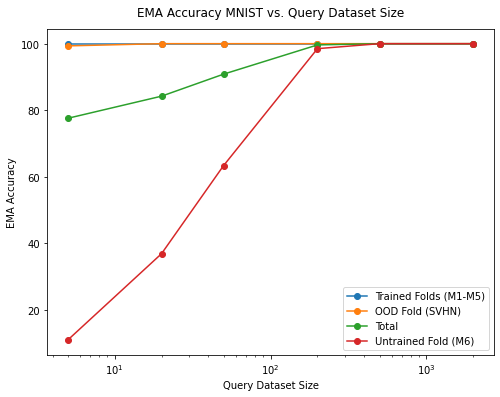

In [209]:
plt.figure(figsize=(8,6))
plt.title('EMA Accuracy MNIST vs. Query Dataset Size', y=1.02)
plt.xlabel("Query Dataset Size")
plt.ylabel("EMA Accuracy")
plt.plot(sizes, m1, marker='o', label="Trained Folds (M1-M5)")
plt.plot(sizes, svhn, marker='o',  label="OOD Fold (SVHN)")
plt.plot(sizes, total, marker='o', label="Total")
plt.plot(sizes, m6, marker='o', label="Untrained Fold (M6)")
plt.legend()
plt.xscale("log")
plt.show()

In [46]:
# covid_tables = []
# for metrics in metric_list:
#     covid_tables.extend(compute_tables(experiments, data, sizes, modes, epoch, metrics, klist, mixup))
# covid_ks = compute_tables(["COVIDx_base"], ['COVIDx'], sizes, ['ks'], epoch, metrics, klist, mixup, cutoff=False)
# covid_reg = compute_tables(["COVIDx_base"], ['COVIDx'], sizes, modes, epoch, metrics, klist, mixup, cutoff=False)
# mnist_ks = compute_tables(["MNIST_base_50"], ['MNIST'], sizes, ['ks'], epoch, metrics, klist, mixup, cutoff=False)
# mnist_reg = compute_tables(["MNIST_base_50"], ['MNIST'], sizes, modes, epoch, metrics, klist, mixup, cutoff=False)
# location_ks = compute_tables(["Location_base_redo"], ['Location'], sizes, ['ks'], 200, metrics, klist, mixup, cutoff=False)
# location_reg = compute_tables(["Location_base_redo"], ['Location'], sizes, modes, 200, metrics, klist, mixup, cutoff=False)
# location_pruning = compute_tables(experiments, data, sizes, modes, epoch, metrics, klist, mixup)
# mnist = compute_tables(drop_size, data, sizes, modes, epoch, metrics, klist, mixup)
lenet_drop_results = compute_tables(lenet_drop, data, sizes, modes, epoch, metrics, klist, mixup)
lenet_prune_results = compute_tables(lenet_sparse, data, sizes, modes, epoch, metrics, klist, mixup)

-----  Query_size:2000 	 Cal data:MNIST  -----
      M1 M2 M3 M4 M5   M6 SVHN
k=100  1  1  1  1  1  0.0  0.0
k=90   1  1  1  1  1  0.0  0.0
k=80   1  1  1  1  1  0.0  0.0
k=70   1  1  1  1  1  0.0  0.0
k=60   1  1  1  1  1  0.0  0.0
k=50   1  1  1  1  1  0.0  0.0 

-----  Query_size:500 	 Cal data:MNIST  -----
      M1 M2 M3 M4 M5   M6 SVHN
k=100  1  1  1  1  1  0.0  0.0
k=90   1  1  1  1  1  0.0  0.0
k=80   1  1  1  1  1  0.0  0.0
k=70   1  1  1  1  1  0.0  0.0
k=60   1  1  1  1  1  0.0  0.0
k=50   1  1  1  1  1  0.0  0.0 

-----  Query_size:200 	 Cal data:MNIST  -----
      M1 M2 M3 M4 M5    M6 SVHN
k=100  1  1  1  1  1   0.0  0.0
k=90   1  1  1  1  1  0.02  0.0
k=80   1  1  1  1  1  0.02  0.0
k=70   1  1  1  1  1   0.0  0.0
k=60   1  1  1  1  1  0.01  0.0
k=50   1  1  1  1  1  0.04  0.0 

-----  Query_size:50 	 Cal data:MNIST  -----
      M1 M2 M3 M4 M5    M6 SVHN
k=100  1  1  1  1  1  0.08  0.0
k=90   1  1  1  1  1  0.16  0.0
k=80   1  1  1  1  1  0.32  0.0
k=70   1  1  1  1  1  0.

         M1 M2 M3 M4 M5   M6 SVHN
k=100  0.32  1  1  1  1  0.0  0.0
k=90   0.32  1  1  1  1  0.0  0.0
k=80   0.32  1  1  1  1  0.0  0.0
k=70   0.32  1  1  1  1  0.0  0.0
k=60   0.32  1  1  1  1  0.0  0.0
k=50   0.32  1  1  1  1  0.0  0.0 

-----  Query_size:500 	 Cal data:MNIST  -----
         M1 M2 M3 M4 M5   M6 SVHN
k=100  0.32  1  1  1  1  0.0  0.0
k=90   0.32  1  1  1  1  0.0  0.0
k=80   0.32  1  1  1  1  0.0  0.0
k=70      1  1  1  1  1  0.0  0.0
k=60      1  1  1  1  1  0.0  0.0
k=50      1  1  1  1  1  0.0  0.0 

-----  Query_size:200 	 Cal data:MNIST  -----
         M1 M2 M3 M4 M5    M6 SVHN
k=100     1  1  1  1  1  0.04  0.0
k=90   0.32  1  1  1  1  0.04  0.0
k=80   0.32  1  1  1  1  0.01  0.0
k=70      1  1  1  1  1  0.16  0.0
k=60      1  1  1  1  1  0.16  0.0
k=50      1  1  1  1  1  0.04  0.0 

-----  Query_size:50 	 Cal data:MNIST  -----
      M1 M2 M3 M4 M5    M6 SVHN
k=100  1  1  1  1  1  0.16  0.0
k=90   1  1  1  1  1     1  0.0
k=80   1  1  1  1  1  0.16  0.0
k=70   1

        M1   M2   M3   M4   M5   M6 SVHN
k=100  0.0  0.0  0.0  0.0  0.0  0.0  0.0
k=90   0.0  0.0  0.0  0.0  0.0  0.0  0.0
k=80   0.0  0.0  0.0  0.0  0.0  0.0  0.0
k=70   0.0  0.0  0.0  0.0  0.0  0.0  0.0
k=60   0.0  0.0  0.0  0.0  0.0  0.0  0.0
k=50   0.0  0.0  0.0  0.0  0.0  0.0  0.0 

-----  Query_size:50 	 Cal data:MNIST  -----
         M1    M2    M3    M4    M5    M6 SVHN
k=100  0.08  0.32  0.32  0.01  0.08  0.16  0.0
k=90   0.08  0.01  0.01  0.01  0.08  0.08  0.0
k=80   0.08  0.16  0.01  0.04  0.08  0.08  0.0
k=70    0.0  0.16  0.08  0.02  0.02   0.0  0.0
k=60   0.02  0.16  0.01     1  0.04  0.16  0.0
k=50   0.01  0.16  0.16  0.01  0.02  0.02  0.0 

-----  Query_size:20 	 Cal data:MNIST  -----
         M1    M2    M3    M4    M5    M6 SVHN
k=100  0.32  0.32     1  0.15  0.15     1  0.0
k=90   0.07  0.15  0.32  0.07  0.32  0.15  0.0
k=80   0.32     1  0.15  0.07  0.07     1  0.0
k=70   0.07  0.15     1  0.32  0.32  0.02  0.0
k=60   0.15  0.15  0.32     1     1     1  0.0
k=50   0

      M1 M2 M3 M4 M5   M6 SVHN
k=100  1  1  1  1  1  0.0  0.0
k=90   1  1  1  1  1  0.0  0.0
k=80   1  1  1  1  1  0.0  0.0
k=70   1  1  1  1  1  0.0  0.0
k=60   1  1  1  1  1  0.0  0.0
k=50   1  1  1  1  1  0.0  0.0 

-----  Query_size:500 	 Cal data:MNIST  -----
      M1 M2 M3 M4 M5    M6 SVHN
k=100  1  1  1  1  1  0.01  0.0
k=90   1  1  1  1  1   0.0  0.0
k=80   1  1  1  1  1   0.0  0.0
k=70   1  1  1  1  1   0.0  0.0
k=60   1  1  1  1  1   0.0  0.0
k=50   1  1  1  1  1  0.01  0.0 

-----  Query_size:200 	 Cal data:MNIST  -----
      M1 M2 M3 M4 M5    M6 SVHN
k=100  1  1  1  1  1  0.32  0.0
k=90   1  1  1  1  1  0.01  0.0
k=80   1  1  1  1  1  0.02  0.0
k=70   1  1  1  1  1  0.02  0.0
k=60   1  1  1  1  1  0.04  0.0
k=50   1  1  1  1  1  0.16  0.0 

-----  Query_size:50 	 Cal data:MNIST  -----
      M1 M2 M3 M4 M5    M6 SVHN
k=100  1  1  1  1  1     1  0.0
k=90   1  1  1  1  1  0.08  0.0
k=80   1  1  1  1  1  0.04  0.0
k=70   1  1  1  1  1  0.32  0.0
k=60   1  1  1  1  1  0.32  0.0


        M1   M2   M3   M4    M5   M6 SVHN
k=100  0.0  0.0  0.0  0.0  0.03  0.0  0.0
k=90   0.0  0.0  0.0  0.0  0.03  0.0  0.0
k=80   0.0  0.0  0.0  0.0  0.03  0.0  0.0
k=70   0.0  0.0  0.0  0.0  0.03  0.0  0.0
k=60   0.0  0.0  0.0  0.0  0.03  0.0  0.0
k=50   0.0  0.0  0.0  0.0  0.03  0.0  0.0 

-----  Query_size:500 	 Cal data:MNIST  -----
         M1    M2    M3    M4    M5   M6 SVHN
k=100  0.16  0.02  0.08  0.08  0.16  0.0  0.0
k=90   0.01  0.08   0.0     1  0.16  0.0  0.0
k=80   0.02  0.08  0.01  0.16  0.32  0.0  0.0
k=70   0.05  0.08   0.0  0.08  0.32  0.0  0.0
k=60   0.02  0.08  0.05  0.02     1  0.0  0.0
k=50   0.08  0.01  0.02  0.05  0.16  0.0  0.0 

-----  Query_size:200 	 Cal data:MNIST  -----
         M1    M2    M3    M4    M5    M6 SVHN
k=100     1  0.32  0.32  0.16     1  0.01  0.0
k=90   0.08  0.32  0.16     1     1  0.04  0.0
k=80   0.16  0.32  0.08  0.32     1  0.04  0.0
k=70   0.32  0.16  0.01  0.32  0.32  0.04  0.0
k=60   0.32     1  0.32  0.32     1   0.0  0.0
k=50  

In [110]:
gan_tables = compute_tables(gan, data, sizes, modes, epoch, metrics, klist, mixup)

-----  Query_size:2000 	 Cal data:MNIST  -----
      M1 M2 M3 M4 M5   M6 SVHN
k=100  1  1  1  1  1  0.0  0.0
k=90   1  1  1  1  1  0.0  0.0
k=80   1  1  1  1  1  0.0  0.0
k=70   1  1  1  1  1  0.0  0.0
k=60   1  1  1  1  1  0.0  0.0
k=50   1  1  1  1  1  0.0  0.0 

-----  Query_size:500 	 Cal data:MNIST  -----
      M1 M2 M3 M4 M5    M6 SVHN
k=100  1  1  1  1  1   0.0  0.0
k=90   1  1  1  1  1  0.01  0.0
k=80   1  1  1  1  1   0.0  0.0
k=70   1  1  1  1  1   0.0  0.0
k=60   1  1  1  1  1   0.0  0.0
k=50   1  1  1  1  1   0.0  0.0 

-----  Query_size:200 	 Cal data:MNIST  -----
      M1 M2 M3 M4 M5    M6 SVHN
k=100  1  1  1  1  1  0.02  0.0
k=90   1  1  1  1  1  0.16  0.0
k=80   1  1  1  1  1  0.02  0.0
k=70   1  1  1  1  1     1  0.0
k=60   1  1  1  1  1  0.04  0.0
k=50   1  1  1  1  1   0.0  0.0 

-----  Query_size:50 	 Cal data:MNIST  -----
      M1 M2 M3 M4 M5    M6 SVHN
k=100  1  1  1  1  1  0.32  0.0
k=90   1  1  1  1  1  0.32  0.0
k=80   1  1  1  1  1  0.16  0.0
k=70   1  1  1  1

      M1 M2 M3 M4 M5    M6 SVHN
k=100  1  1  1  1  1   0.0  0.0
k=90   1  1  1  1  1   0.0  0.0
k=80   1  1  1  1  1  0.01  0.0
k=70   1  1  1  1  1  0.01  0.0
k=60   1  1  1  1  1   0.0  0.0
k=50   1  1  1  1  1   0.0  0.0 

-----  Query_size:200 	 Cal data:MNIST  -----
      M1 M2 M3 M4 M5    M6 SVHN
k=100  1  1  1  1  1  0.02  0.0
k=90   1  1  1  1  1  0.16  0.0
k=80   1  1  1  1  1  0.08  0.0
k=70   1  1  1  1  1  0.16  0.0
k=60   1  1  1  1  1  0.08  0.0
k=50   1  1  1  1  1  0.04  0.0 

-----  Query_size:50 	 Cal data:MNIST  -----
      M1 M2 M3 M4 M5    M6 SVHN
k=100  1  1  1  1  1  0.16  0.0
k=90   1  1  1  1  1     1  0.0
k=80   1  1  1  1  1     1  0.0
k=70   1  1  1  1  1     1  0.0
k=60   1  1  1  1  1  0.08  0.0
k=50   1  1  1  1  1  0.32  0.0 

-----  Query_size:20 	 Cal data:MNIST  -----
      M1 M2 M3 M4 M5    M6 SVHN
k=100  1  1  1  1  1     1  0.0
k=90   1  1  1  1  1     1  0.0
k=80   1  1  1  1  1     1  0.0
k=70   1  1  1  1  1     1  0.0
k=60   1  1  1  1  1  0.07

In [167]:
ema_accuracy(gan_tables, weights=[50,25, 25], detailed=False)

Lenet_MNIST: 91.5625
Lenet_MNIST M6: 66.24999999999999
Lenet_MNIST M1: 100.0
MNIST_GAN20: 86.18055555555554
MNIST_GAN20 M6: 45.80555555555555
MNIST_GAN20 M1: 100.0
MNIST_GAN100: 91.20833333333333
MNIST_GAN100 M6: 65.72222222222221
MNIST_GAN100 M1: 100.0
MNIST_GAN1000: 89.52083333333333
MNIST_GAN1000 M6: 59.083333333333336
MNIST_GAN1000 M1: 100.0
MNIST_GAN2000: 89.19444444444444
MNIST_GAN2000 M6: 56.888888888888886
MNIST_GAN2000 M1: 100.0
MNIST_GAN5000: 89.77777777777779
MNIST_GAN5000 M6: 59.611111111111114
MNIST_GAN5000 M1: 100.0
MNIST_GAN10000: 90.02777777777777
MNIST_GAN10000 M6: 60.333333333333336
MNIST_GAN10000 M1: 100.0
MNIST_GAN20000: 91.625
MNIST_GAN20000 M6: 67.22222222222223
MNIST_GAN20000 M1: 100.0
MNIST_GAN50000: 89.90277777777779
MNIST_GAN50000 M6: 60.97222222222223
MNIST_GAN50000 M1: 100.0
MNIST_GAN60000: 90.74305555555556
MNIST_GAN60000 M6: 63.69444444444446
MNIST_GAN60000 M1: 100.0
[91.5625, 86.18055555555554, 91.20833333333333, 89.52083333333333, 89.19444444444444, 89.7

In [169]:
sizes = [20, 100, 1000, 2000, 5000, 10000, 20000, 50000, 60000]
gan_ema = [86.18055555555554, 91.20833333333333, 89.52083333333333, 89.19444444444444, 89.77777777777779, 90.02777777777777, 91.625, 89.90277777777779, 90.74305555555556]
gan_acc = [9.78, 9.78, 15.75, 30.39, 77.30, 88.03, 94.93, 96.33, 96.36]

gan_m6 = [45.81, 65.72, 59.08, 56.89, 59.61, 60.33, 67.22, 60.97, 63.69]

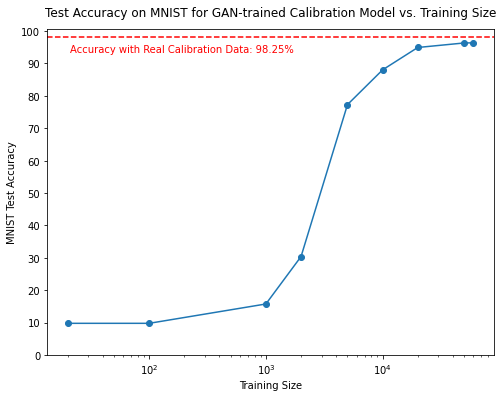

In [157]:
plt.figure(figsize=(8,6))
plt.title('Test Accuracy on MNIST for GAN-trained Calibration Model vs. Training Size', y=1.02)
plt.xlabel("Training Size")
plt.ylabel("MNIST Test Accuracy")
plt.plot(sizes, gan_acc, marker='o', label="Two-Layer MLP")
plt.axhline(98.25, color='r', linestyle='--')
plt.yticks(np.arange(0, 101, 10))
plt.annotate("Accuracy with Real Calibration Data: 98.25%", (20, 98), color='red', textcoords="offset points", xytext=(2, -15))
plt.xscale("log")
plt.show()

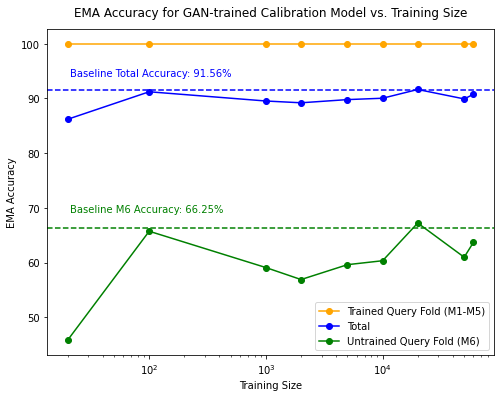

In [195]:
plt.figure(figsize=(8,6))
plt.title('EMA Accuracy for GAN-trained Calibration Model vs. Training Size', y=1.02)
plt.xlabel("Training Size")
plt.ylabel("EMA Accuracy")
plt.plot(sizes, [100] * len(sizes), marker = 'o', color='orange', label = 'Trained Query Fold (M1-M5)')
plt.plot(sizes, gan_ema, marker='o', color='blue', label="Total")
plt.plot(sizes, gan_m6, marker='o', color='green', label="Untrained Query Fold (M6)")
plt.axhline(91.56, color='blue', linestyle='--')
plt.axhline(66.25, color='g', linestyle='--')
plt.annotate("Baseline M6 Accuracy: 66.25%", (20, 72), color='green', textcoords="offset points", xytext=(2, -15))
plt.annotate("Baseline Total Accuracy: 91.56%", (20, 94), color='blue', textcoords="offset points", xytext=(2, 0))
plt.legend()
plt.xscale("log")
plt.show()

In [78]:
small_mnist = compute_tables(small_mnist, data, sizes, modes, epoch, metrics, klist, mixup)

-----  Query_size:2000 	 Cal data:MNIST  -----
      M1 M2 M3 M4 M5   M6 SVHN
k=100  1  1  1  1  1  0.0  0.0
k=90   1  1  1  1  1  0.0  0.0
k=80   1  1  1  1  1  0.0  0.0
k=70   1  1  1  1  1  0.0  0.0
k=60   1  1  1  1  1  0.0  0.0
k=50   1  1  1  1  1  0.0  0.0 

-----  Query_size:500 	 Cal data:MNIST  -----
      M1 M2 M3 M4 M5   M6 SVHN
k=100  1  1  1  1  1  0.0  0.0
k=90   1  1  1  1  1  0.0  0.0
k=80   1  1  1  1  1  0.0  0.0
k=70   1  1  1  1  1  0.0  0.0
k=60   1  1  1  1  1  0.0  0.0
k=50   1  1  1  1  1  0.0  0.0 

-----  Query_size:200 	 Cal data:MNIST  -----
      M1 M2 M3 M4 M5    M6 SVHN
k=100  1  1  1  1  1   0.0  0.0
k=90   1  1  1  1  1  0.02  0.0
k=80   1  1  1  1  1  0.02  0.0
k=70   1  1  1  1  1   0.0  0.0
k=60   1  1  1  1  1  0.01  0.0
k=50   1  1  1  1  1  0.04  0.0 

-----  Query_size:50 	 Cal data:MNIST  -----
      M1 M2 M3 M4 M5    M6 SVHN
k=100  1  1  1  1  1  0.08  0.0
k=90   1  1  1  1  1  0.16  0.0
k=80   1  1  1  1  1  0.32  0.0
k=70   1  1  1  1  1  0.

      M1 M2 M3 M4 M5   M6 SVHN
k=100  1  1  1  1  1  0.0  0.0
k=90   1  1  1  1  1  0.0  0.0
k=80   1  1  1  1  1  0.0  0.0
k=70   1  1  1  1  1  0.0  0.0
k=60   1  1  1  1  1  0.0  0.0
k=50   1  1  1  1  1  0.0  0.0 

-----  Query_size:200 	 Cal data:MNIST  -----
      M1 M2 M3 M4 M5    M6 SVHN
k=100  1  1  1  1  1   0.0  0.0
k=90   1  1  1  1  1  0.01  0.0
k=80   1  1  1  1  1   0.0  0.0
k=70   1  1  1  1  1   0.0  0.0
k=60   1  1  1  1  1  0.01  0.0
k=50   1  1  1  1  1   0.0  0.0 

-----  Query_size:50 	 Cal data:MNIST  -----
      M1 M2 M3 M4 M5    M6 SVHN
k=100  1  1  1  1  1  0.08  0.0
k=90   1  1  1  1  1  0.08  0.0
k=80   1  1  1  1  1     1  0.0
k=70   1  1  1  1  1  0.16  0.0
k=60   1  1  1  1  1  0.08  0.0
k=50   1  1  1  1  1  0.32  0.0 

-----  Query_size:20 	 Cal data:MNIST  -----
      M1 M2 M3 M4 M5    M6 SVHN
k=100  1  1  1  1  1  0.32  0.0
k=90   1  1  1  1  1  0.15  0.0
k=80   1  1  1  1  1     1  0.0
k=70   1  1  1  1  1     1  0.0
k=60   1  1  1  1  1  0.07  0.0
k

         M1 M2 M3 M4    M5    M6 SVHN
k=100  0.32  1  1  1  0.32  0.32  0.0
k=90      1  1  1  1     1  0.07  0.0
k=80      1  1  1  1     1  0.15  0.0
k=70   0.32  1  1  1  0.32  0.32  0.0
k=60      1  1  1  1     1  0.15  0.0
k=50      1  1  1  1     1  0.32  0.0 

-----  Query_size:5 	 Cal data:MNIST  -----
      M1 M2 M3 M4    M5 M6 SVHN
k=100  1  1  1  1  0.35  1  0.0
k=90   1  1  1  1     1  1  0.0
k=80   1  1  1  1     1  1  0.0
k=70   1  1  1  1     1  1  0.0
k=60   1  1  1  1     1  1  0.0
k=50   1  1  1  1     1  1  0.0 

-----  Query_size:2000 	 Cal data:MNIST  -----
        M1   M2   M3   M4   M5   M6 SVHN
k=100  0.0  0.0  0.0  0.0  0.0  0.0  0.0
k=90   0.0  0.0  0.0  0.0  0.0  0.0  0.0
k=80   0.0  0.0  0.0  0.0  0.0  0.0  0.0
k=70   0.0  0.0  0.0  0.0  0.0  0.0  0.0
k=60   0.0  0.0  0.0  0.0  0.0  0.0  0.0
k=50   0.0  0.0  0.0  0.0  0.0  0.0  0.0 

-----  Query_size:500 	 Cal data:MNIST  -----
        M1   M2   M3   M4   M5   M6 SVHN
k=100  0.0  0.0  0.0  0.0  0.0  0.0  0.

In [79]:
ema_accuracy(small_mnist, weights=[50, 25, 25], detailed=False)

MNIST_base_50: 92.03472222222221
SmallMNIST0.0: 91.95833333333333
SmallMNIST0.1: 92.90277777777777
SmallMNIST0.2: 89.47222222222223
SmallMNIST0.3: 93.11805555555556
SmallMNIST0.4: 93.99305555555556
SmallMNIST0.5: 93.125
SmallMNIST0.6: 85.95972222222223
SmallMNIST0.7: 72.7375
SmallMNIST0.8: 70.45694444444445
SmallMNIST0.9: 58.74861111111111
[92.03472222222221, 91.95833333333333, 92.90277777777777, 89.47222222222223, 93.11805555555556, 93.99305555555556, 93.125, 85.95972222222223, 72.7375, 70.45694444444445, 58.74861111111111]


In [86]:
fnn_acc = np.array([96.24, 96.33, 96.40, 96.36, 96.16, 95.92, 95.35, 94.61, 93.10, 84.36])
fnn_ema = np.array([92.03, 91.03, 91.89, 91.14, 91.13, 85.45, 74.29, 71.78, 63.20, 56.06])

two_ema = np.array([91.95833333333333, 92.90277777777777, 89.47222222222223, 93.11805555555556, 93.99305555555556, 93.125, 85.95972222222223, 72.7375, 70.45694444444445, 58.74861111111111])
two_acc = np.array([96.21, 96.31, 96.33, 96.28, 96.46, 96.39, 96.14, 96.04, 95.79, 93.60])

fnn_drop_emacost = fnn_ema[0] - fnn_ema
two_drop_emacost = two_ema[0] - two_ema

fnn_drop_acccost = fnn_acc[0] - fnn_acc
two_drop_acccost = two_acc[0] - two_acc

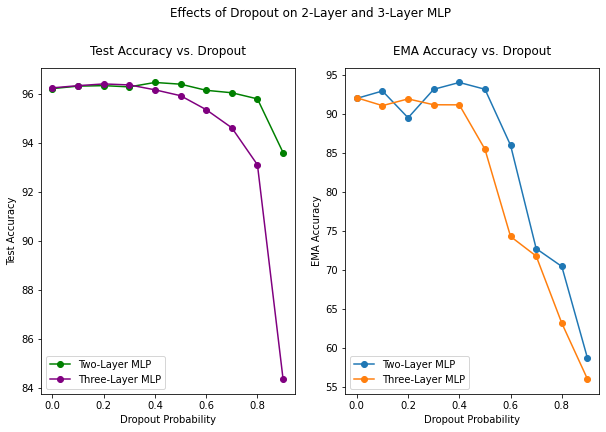

In [107]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle("Effects of Dropout on 2-Layer and 3-Layer MLP", y=1.02)
dropout = np.arange(0, 1, 0.1)
ax1.set_title('Test Accuracy vs. Dropout', y=1.02)
ax1.set_ylabel("Test Accuracy")
ax1.set_xlabel("Dropout Probability")
ax1.plot(dropout, two_acc, marker='o', color='g', label="Two-Layer MLP")
ax1.plot(dropout, fnn_acc, marker='o', color='purple', label="Three-Layer MLP")
ax1.legend()

ax2.set_title('EMA Accuracy vs. Dropout', y=1.02)
ax2.set_ylabel("EMA Accuracy")
ax2.set_xlabel("Dropout Probability")
ax2.plot(dropout, two_ema, marker='o', label="Two-Layer MLP")
ax2.plot(dropout, fnn_ema, marker='o', label="Three-Layer MLP")
ax2.legend()

plt.show()

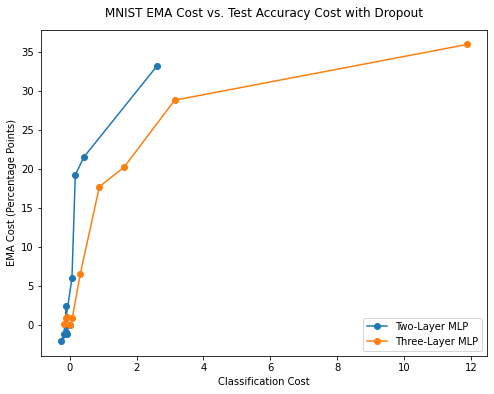

In [95]:
plt.figure(figsize=(8,6))
plt.title('MNIST EMA Cost vs. Test Accuracy Cost with Dropout', y=1.02)
plt.xlabel("Classification Cost")
plt.ylabel("EMA Cost (Percentage Points)")
plt.plot(two_drop_acccost, two_drop_emacost, marker='o', label="Two-Layer MLP")
plt.plot(fnn_drop_acccost, fnn_drop_emacost, marker='o', label="Three-Layer MLP")
plt.legend()
plt.show()

In [70]:
fnn_acc = np.array([96.24, 96.33, 96.40, 96.36, 96.16, 95.92, 95.35, 94.61, 93.10, 84.36])
fnn_ema = np.array([92.03, 91.03, 91.89, 91.14, 91.13, 85.45, 74.29, 71.78, 63.20, 56.06])

lenet_acc = np.array([98.25, 97.88, 98.01, 98.01, 97.97, 97.34, 97.49, 97.05, 91.38])
lenet_ema = np.array([91.56, 91.67, 90.34, 90.27, 84.68, 77.39, 73.01, 60.63, 54.29])

lenet_acc_prune = np.array([98.25, 98.28, 98.25, 98.25, 98.26, 98.20, 98.20, 97.75, 97.28, 91.90])
lenet_ema_prune = np.array([91.56, 90.16, 88.37, 91.53, 90.03, 91.41, 85.51, 79.23, 69.28, 54.13])

fnn_ema_prune = np.array([92.03472222222221, 85.62638888888888, 83.54722222222222, 86.91527777777777, 84.6111111111111, 85.49583333333334, 82.41666666666667, 84.6875, 87.45555555555556, 85.83611111111111, 84.89722222222223, 87.0])
fnn_acc_prune = np.array([97.0, 97.0, 97.0, 97.0, 97.0, 96.9, 96.7, 96.5, 96.2, 95.9, 95.2, 77.0])

fnn_drop_emacost = fnn_ema[0] - fnn_ema
lenet_drop_emacost = lenet_ema[0] - lenet_ema

fnn_drop_acccost = fnn_acc[0] - fnn_acc
lenet_drop_acccost = lenet_acc[0] - lenet_acc

####

fnn_prune_emacost = fnn_ema_prune[0] - fnn_ema_prune
lenet_prune_emacost = lenet_ema_prune[0] - lenet_ema_prune

fnn_prune_acccost = fnn_acc_prune[0] - fnn_acc_prune
lenet_prune_acccost = lenet_acc_prune[0] - lenet_acc_prune

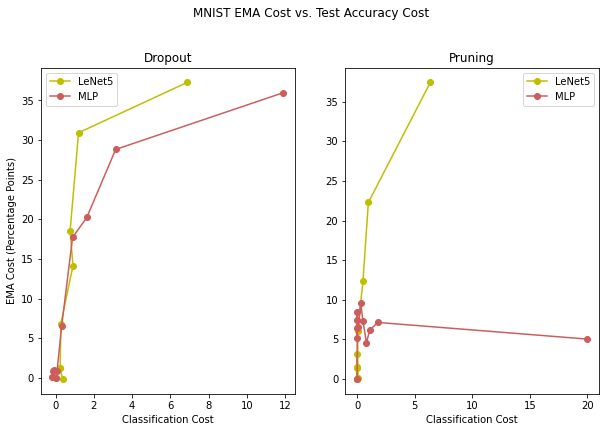

In [82]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

plt.suptitle('MNIST EMA Cost vs. Test Accuracy Cost', y=1.02)
ax1.set_xlabel("Classification Cost")
ax2.set_xlabel("Classification Cost")
ax1.set_ylabel("EMA Cost (Percentage Points)")
ax1.set_title("Dropout")
ax2.set_title("Pruning")
ax1.plot(lenet_drop_acccost, lenet_drop_emacost, marker='o', color='y', label="LeNet5")
ax1.plot(fnn_drop_acccost, fnn_drop_emacost, marker='o', color='indianred', label="MLP")

ax2.plot(lenet_prune_acccost, lenet_prune_emacost, marker='o', color='y', label="LeNet5")
ax2.plot(fnn_prune_acccost, fnn_prune_emacost, marker='o', color='indianred', label="MLP")
ax1.legend()
ax2.legend()
plt.show()

In [38]:
covid_tables = []
for metrics in metric_list:
    covid_tables.extend(compute_tables(covid_sparsity, data, sizes, modes, epoch, metrics, klist, mixup))

-----  Query_size:2000 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5   C6 Chest
k=100  1  1  1  1  1  0.0   0.0
k=90   1  1  1  1  1  0.0   0.0
k=80   1  1  1  1  1  0.0   0.0
k=70   1  1  1  1  1  0.0   0.0
k=60   1  1  1  1  1  0.0   0.0
k=50   1  1  1  1  1  0.0   0.0 

-----  Query_size:500 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5   C6 Chest
k=100  1  1  1  1  1  0.0   0.0
k=90   1  1  1  1  1  0.0   0.0
k=80   1  1  1  1  1  0.0   0.0
k=70   1  1  1  1  1  0.0   0.0
k=60   1  1  1  1  1  0.0   0.0
k=50   1  1  1  1  1  0.0   0.0 

-----  Query_size:200 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5   C6 Chest
k=100  1  1  1  1  1  0.0   0.0
k=90   1  1  1  1  1  0.0   0.0
k=80   1  1  1  1  1  0.0   0.0
k=70   1  1  1  1  1  0.0   0.0
k=60   1  1  1  1  1  0.0   0.0
k=50   1  1  1  1  1  0.0   0.0 

-----  Query_size:50 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5    C6 Chest
k=100  1  1  1  1  1  0.01   0.0
k=90   1  1  1  1  1  0.01   0.0
k=80   1  1  1  1  1  0.08  0.01
k=

         C1    C2    C3    C4    C5    C6 Chest
k=100   0.0   0.0   0.0   0.0   0.0   0.0   0.0
k=90    0.0   0.0   0.0   0.0   0.0   0.0   0.0
k=80    0.0   0.0   0.0   0.0   0.0   0.0   0.0
k=70    0.0   0.0   0.0   0.0   0.0   0.0   0.0
k=60    0.0   0.0   0.0   0.0   0.0   0.0   0.0
k=50   0.04  0.04  0.16  0.04  0.16  0.04   0.0 

-----  Query_size:50 	 Cal data:COVIDx  -----
         C1    C2    C3    C4    C5    C6 Chest
k=100  0.16  0.01  0.02   0.0  0.02   0.0   0.0
k=90   0.04  0.04  0.08  0.16  0.02  0.04   0.0
k=80   0.08  0.08  0.16  0.16  0.08  0.01   0.0
k=70    0.0  0.04   0.0  0.01  0.01  0.02  0.01
k=60   0.16  0.08  0.32  0.08  0.02   0.0  0.01
k=50      1     1  0.32  0.32     1  0.32  0.08 

-----  Query_size:20 	 Cal data:COVIDx  -----
         C1    C2    C3    C4    C5    C6 Chest
k=100     1  0.15  0.07  0.15  0.07  0.32  0.01
k=90   0.15  0.15  0.32  0.32  0.32  0.15  0.02
k=80   0.15  0.07  0.32     1  0.32  0.07  0.01
k=70   0.15  0.07  0.02  0.04  0.15  0.1

        C1   C2    C3    C4    C5   C6 Chest
k=100  0.0  0.0   0.0   0.0   0.0  0.0   0.0
k=90   0.0  0.0   0.0   0.0   0.0  0.0   0.0
k=80   0.0  0.0   0.0   0.0   0.0  0.0   0.0
k=70   0.0  0.0   0.0   0.0   0.0  0.0   0.0
k=60   0.0  0.0   0.0   0.0   0.0  0.0   0.0
k=50     1    1  0.32  0.32  0.32    1  0.16 

-----  Query_size:200 	 Cal data:COVIDx  -----
        C1   C2    C3   C4   C5   C6 Chest
k=100  0.0  0.0   0.0  0.0  0.0  0.0   0.0
k=90   0.0  0.0   0.0  0.0  0.0  0.0   0.0
k=80   0.0  0.0   0.0  0.0  0.0  0.0   0.0
k=70   0.0  0.0   0.0  0.0  0.0  0.0   0.0
k=60   0.0  0.0   0.0  0.0  0.0  0.0   0.0
k=50     1    1  0.32    1    1    1     1 

-----  Query_size:50 	 Cal data:COVIDx  -----
        C1   C2    C3   C4   C5   C6 Chest
k=100  0.0  0.0   0.0  0.0  0.0  0.0   0.0
k=90   0.0  0.0   0.0  0.0  0.0  0.0   0.0
k=80   0.0  0.0   0.0  0.0  0.0  0.0   0.0
k=70   0.0  0.0   0.0  0.0  0.0  0.0   0.0
k=60   0.0  0.0   0.0  0.0  0.0  0.0   0.0
k=50     1    1  0.32    1   

         C1    C2    C3    C4    C5    C6 Chest
k=100     1     1     1     1  0.32  0.04  0.01
k=90      1  0.32     1  0.32     1  0.02  0.07
k=80      1     1  0.32  0.32     1  0.01   0.0
k=70      1     1  0.32     1     1  0.02   0.0
k=60      1     1     1     1     1  0.01   0.0
k=50   0.32     1  0.32     1     1  0.04  0.02 

-----  Query_size:5 	 Cal data:COVIDx  -----
      C1 C2    C3 C4 C5    C6 Chest
k=100  1  1     1  1  1     1  0.35
k=90   1  1     1  1  1  0.35  0.35
k=80   1  1  0.35  1  1  0.35  0.14
k=70   1  1  0.35  1  1  0.04  0.35
k=60   1  1     1  1  1     1  0.14
k=50   1  1     1  1  1  0.35  0.35 

-----  Query_size:2000 	 Cal data:COVIDx  -----
        C1   C2   C3   C4   C5   C6 Chest
k=100  0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=90   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=80   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=70   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=60   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=50   0.0  0.0  0.0  0.0  0.0  0.0   0.0 

-----  Query_size:5

         C1    C2    C3    C4    C5    C6 Chest
k=100   0.0  0.02  0.15  0.01   0.0  0.02   0.0
k=90   0.01   0.0   0.0   0.0   0.0   0.0   0.0
k=80    0.0  0.02   0.0   0.0   0.0   0.0   0.0
k=70    0.0   0.0   0.0  0.02   0.0  0.04   0.0
k=60    0.0   0.0   0.0  0.02  0.04   0.0   0.0
k=50    0.0   0.0   0.0  0.01   0.0   0.0   0.0 

-----  Query_size:5 	 Cal data:COVIDx  -----
         C1    C2    C3    C4    C5    C6 Chest
k=100  0.14  0.14  0.14  0.35  0.14  0.14  0.04
k=90   0.14  0.14  0.35  0.35  0.14  0.14  0.14
k=80    0.0     1  0.14  0.04  0.14  0.35  0.14
k=70   0.04  0.04  0.14  0.35  0.04  0.35  0.04
k=60   0.35  0.35  0.14     1     1  0.35  0.14
k=50   0.04  0.14  0.14  0.35  0.14  0.04     1 

-----  Query_size:2000 	 Cal data:COVIDx  -----
        C1   C2   C3   C4   C5   C6 Chest
k=100  0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=90   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=80   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=70   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=60   0.0  0.0  0.0 

         C1    C2    C3    C4    C5    C6 Chest
k=100  0.32  0.32  0.15  0.32  0.04   0.0   0.0
k=90      1     1     1     1     1   0.0   0.0
k=80      1     1     1     1     1  0.01   0.0
k=70      1     1     1     1     1  0.01   0.0
k=60      1     1     1     1     1  0.07  0.15
k=50      1     1     1     1     1  0.07  0.04 

-----  Query_size:5 	 Cal data:COVIDx  -----
      C1 C2 C3 C4    C5    C6 Chest
k=100  1  1  1  1  0.14  0.04   0.0
k=90   1  1  1  1     1  0.14   0.0
k=80   1  1  1  1     1     1  0.04
k=70   1  1  1  1     1  0.35  0.14
k=60   1  1  1  1     1     1     1
k=50   1  1  1  1     1     1  0.35 

-----  Query_size:2000 	 Cal data:COVIDx  -----
        C1   C2   C3   C4   C5   C6 Chest
k=100  0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=90   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=80   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=70   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=60     1    1    1    1    1  0.0   0.0
k=50     1    1    1    1    1  0.0   0.0 

-----  Query_size:5

         C1    C2    C3    C4    C5    C6 Chest
k=100   0.0   0.0   0.0   0.0   0.0   0.0   0.0
k=90    0.0   0.0   0.0   0.0   0.0   0.0   0.0
k=80   0.01   0.0   0.0   0.0   0.0   0.0   0.0
k=70   0.04   0.0  0.02   0.0   0.0  0.02   0.0
k=60   0.32     1     1  0.32  0.15  0.07  0.15
k=50   0.15  0.04  0.15  0.15  0.32  0.07  0.02 

-----  Query_size:5 	 Cal data:COVIDx  -----
         C1    C2    C3    C4    C5    C6 Chest
k=100  0.35  0.04  0.14  0.35  0.14   0.0   0.0
k=90    0.0   0.0  0.14  0.04  0.04   0.0   0.0
k=80   0.35  0.14  0.04  0.14  0.14   0.0   0.0
k=70   0.35  0.04  0.35  0.35  0.04  0.14  0.04
k=60      1     1     1  0.35  0.35     1  0.35
k=50   0.35  0.35     1     1     1  0.35  0.14 

-----  Query_size:2000 	 Cal data:COVIDx  -----
        C1   C2   C3   C4   C5   C6 Chest
k=100  0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=90   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=80   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=70   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=60   0.0  0.0  0.0 

        C1    C2    C3   C4    C5    C6 Chest
k=100  0.0   0.0   0.0  0.0   0.0   0.0   0.0
k=90   0.0   0.0   0.0  0.0   0.0   0.0   0.0
k=80   0.0   0.0   0.0  0.0   0.0   0.0   0.0
k=70   0.0   0.0   0.0  0.0  0.02  0.02   0.0
k=60   0.0   0.0   0.0  0.0   0.0   0.0   0.0
k=50   0.0  0.02  0.04  0.0   0.0   0.0   0.0 

-----  Query_size:5 	 Cal data:COVIDx  -----
         C1    C2    C3    C4    C5    C6 Chest
k=100   0.0   0.0   0.0   0.0   0.0   0.0   0.0
k=90    0.0   0.0   0.0   0.0   0.0   0.0   0.0
k=80    0.0  0.04   0.0   0.0   0.0   0.0   0.0
k=70   0.04  0.14     1   0.0     1  0.35  0.14
k=60      1  0.04  0.14  0.35  0.35  0.14   0.0
k=50   0.35     1  0.35  0.35   0.0  0.35  0.04 

-----  Query_size:2000 	 Cal data:COVIDx  -----
        C1   C2   C3    C4   C5   C6 Chest
k=100  0.0  0.0  0.0   0.0  0.0  0.0   0.0
k=90   0.0  0.0  0.0  0.08  0.0  0.0   0.0
k=80   0.0  0.0  0.0   0.0  0.0  0.0   0.0
k=70   0.0  0.0  0.0   0.0  0.0  0.0   0.0
k=60   0.0  0.0  0.0   0.0  0.

         C1    C2    C3    C4    C5   C6 Chest
k=100   0.0   0.0   0.0   0.0   0.0  0.0   0.0
k=90   0.01   0.0  0.02  0.01   0.0  0.0   0.0
k=80   0.04  0.01  0.02   0.0   0.0  0.0   0.0
k=70   0.01  0.04   0.0   0.0  0.04  0.0   0.0
k=60    0.0   0.0   0.0   0.0   0.0  0.0   0.0
k=50    0.0   0.0   0.0   0.0   0.0  0.0   0.0 

-----  Query_size:5 	 Cal data:COVIDx  -----
         C1    C2    C3    C4    C5    C6 Chest
k=100  0.14  0.14   0.0  0.04  0.04  0.35  0.04
k=90   0.35  0.14  0.04  0.35   0.0   0.0   0.0
k=80   0.35  0.35  0.35  0.14  0.35  0.14  0.04
k=70   0.35  0.35  0.04  0.14  0.14   0.0  0.04
k=60    0.0  0.04   0.0  0.04  0.04  0.04   0.0
k=50   0.35  0.14  0.35  0.04  0.14  0.35   0.0 

-----  Query_size:2000 	 Cal data:COVIDx  -----
        C1   C2   C3   C4   C5   C6 Chest
k=100  0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=90   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=80   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=70   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=60   0.0  0.0  0.0  0.0  0

         C1   C2    C3   C4   C5    C6 Chest
k=100   0.0  0.0   0.0  0.0  0.0   0.0   0.0
k=90    0.0  0.0   0.0  0.0  0.0   0.0   0.0
k=80    0.0  0.0   0.0  0.0  0.0   0.0   0.0
k=70    0.0  0.0   0.0  0.0  0.0   0.0   0.0
k=60    0.0  0.0   0.0  0.0  0.0   0.0   0.0
k=50   0.04  0.0  0.02  0.0  0.0  0.01  0.01 

-----  Query_size:5 	 Cal data:COVIDx  -----
         C1   C2    C3    C4    C5    C6 Chest
k=100   0.0  0.0   0.0   0.0   0.0   0.0   0.0
k=90    0.0  0.0   0.0   0.0   0.0   0.0   0.0
k=80    0.0  0.0   0.0   0.0   0.0   0.0   0.0
k=70    0.0  0.0   0.0   0.0   0.0   0.0   0.0
k=60    0.0  0.0   0.0   0.0   0.0   0.0   0.0
k=50   0.35    1  0.35  0.14  0.04  0.04  0.04 

-----  Query_size:2000 	 Cal data:COVIDx  -----
        C1   C2   C3   C4   C5   C6 Chest
k=100  0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=90   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=80   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=70   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=60   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=50   

         C1    C2    C3    C4    C5    C6 Chest
k=100  0.32  0.32  0.15  0.32  0.04   0.0   0.0
k=90      1     1     1     1     1   0.0   0.0
k=80      1     1     1     1     1  0.01   0.0
k=70      1     1     1     1     1  0.01   0.0
k=60      1     1     1     1     1  0.07  0.15
k=50      1     1     1     1     1  0.07  0.04 

-----  Query_size:5 	 Cal data:COVIDx  -----
      C1 C2 C3 C4    C5    C6 Chest
k=100  1  1  1  1  0.14  0.04   0.0
k=90   1  1  1  1     1  0.14   0.0
k=80   1  1  1  1     1     1  0.04
k=70   1  1  1  1     1  0.35  0.14
k=60   1  1  1  1     1     1     1
k=50   1  1  1  1     1     1  0.35 

-----  Query_size:2000 	 Cal data:COVIDx  -----
        C1   C2   C3   C4   C5   C6 Chest
k=100  0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=90   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=80   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=70   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=60     1    1    1    1    1  0.0   0.0
k=50     1    1    1    1    1  0.0   0.0 

-----  Query_size:5

         C1    C2    C3    C4    C5    C6 Chest
k=100   0.0   0.0   0.0   0.0   0.0   0.0   0.0
k=90    0.0   0.0   0.0   0.0   0.0   0.0   0.0
k=80   0.01   0.0   0.0   0.0   0.0   0.0   0.0
k=70   0.04   0.0  0.02   0.0   0.0  0.02   0.0
k=60   0.32     1     1  0.32  0.15  0.07  0.15
k=50   0.15  0.04  0.15  0.15  0.32  0.07  0.02 

-----  Query_size:5 	 Cal data:COVIDx  -----
         C1    C2    C3    C4    C5    C6 Chest
k=100  0.35  0.04  0.14  0.35  0.14   0.0   0.0
k=90    0.0   0.0  0.14  0.04  0.04   0.0   0.0
k=80   0.35  0.14  0.04  0.14  0.14   0.0   0.0
k=70   0.35  0.04  0.35  0.35  0.04  0.14  0.04
k=60      1     1     1  0.35  0.35     1  0.35
k=50   0.35  0.35     1     1     1  0.35  0.14 

-----  Query_size:2000 	 Cal data:COVIDx  -----
        C1   C2   C3   C4   C5   C6 Chest
k=100  0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=90   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=80   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=70   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=60   0.0  0.0  0.0 

        C1    C2    C3   C4    C5    C6 Chest
k=100  0.0   0.0   0.0  0.0   0.0   0.0   0.0
k=90   0.0   0.0   0.0  0.0   0.0   0.0   0.0
k=80   0.0   0.0   0.0  0.0   0.0   0.0   0.0
k=70   0.0   0.0   0.0  0.0  0.02  0.02   0.0
k=60   0.0   0.0   0.0  0.0   0.0   0.0   0.0
k=50   0.0  0.02  0.04  0.0   0.0   0.0   0.0 

-----  Query_size:5 	 Cal data:COVIDx  -----
         C1    C2    C3    C4    C5    C6 Chest
k=100   0.0   0.0   0.0   0.0   0.0   0.0   0.0
k=90    0.0   0.0   0.0   0.0   0.0   0.0   0.0
k=80    0.0  0.04   0.0   0.0   0.0   0.0   0.0
k=70   0.04  0.14     1   0.0     1  0.35  0.14
k=60      1  0.04  0.14  0.35  0.35  0.14   0.0
k=50   0.35     1  0.35  0.35   0.0  0.35  0.04 

-----  Query_size:2000 	 Cal data:COVIDx  -----
        C1   C2   C3    C4   C5   C6 Chest
k=100  0.0  0.0  0.0   0.0  0.0  0.0   0.0
k=90   0.0  0.0  0.0  0.08  0.0  0.0   0.0
k=80   0.0  0.0  0.0   0.0  0.0  0.0   0.0
k=70   0.0  0.0  0.0   0.0  0.0  0.0   0.0
k=60   0.0  0.0  0.0   0.0  0.

         C1    C2    C3    C4    C5    C6 Chest
k=100   0.0   0.0   0.0   0.0   0.0   0.0   0.0
k=90   0.01   0.0  0.07  0.01   0.0   0.0   0.0
k=80   0.04  0.02  0.02   0.0   0.0   0.0   0.0
k=70   0.02  0.07   0.0  0.01  0.07   0.0   0.0
k=60      1     1     1     1     1  0.02  0.01
k=50   0.32     1  0.32     1     1  0.04  0.04 

-----  Query_size:5 	 Cal data:COVIDx  -----
         C1    C2    C3    C4    C5    C6 Chest
k=100  0.14  0.14   0.0  0.04  0.04  0.35   0.0
k=90   0.35  0.14  0.35  0.35   0.0   0.0  0.04
k=80   0.35  0.35  0.35  0.14  0.35  0.14  0.04
k=70   0.35  0.35  0.04  0.14  0.14   0.0  0.35
k=60      1     1     1     1     1     1  0.14
k=50      1     1     1     1     1  0.35  0.35 

-----  Query_size:2000 	 Cal data:COVIDx  -----
        C1   C2   C3   C4   C5   C6 Chest
k=100  0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=90   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=80   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=70   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=60   0.0  0.0  0.0 

         C1    C2    C3    C4    C5    C6 Chest
k=100   0.0   0.0   0.0   0.0   0.0   0.0   0.0
k=90    0.0   0.0   0.0   0.0   0.0   0.0   0.0
k=80    0.0   0.0   0.0   0.0   0.0   0.0   0.0
k=70    0.0   0.0   0.0   0.0   0.0   0.0   0.0
k=60   0.01  0.04  0.02  0.15  0.07  0.02  0.01
k=50    0.0  0.04  0.01  0.02   0.0   0.0   0.0 

-----  Query_size:5 	 Cal data:COVIDx  -----
         C1    C2    C3    C4    C5    C6 Chest
k=100   0.0   0.0   0.0   0.0   0.0   0.0   0.0
k=90    0.0   0.0   0.0   0.0   0.0   0.0   0.0
k=80    0.0   0.0   0.0   0.0   0.0   0.0   0.0
k=70    0.0  0.04  0.04  0.35  0.04  0.04  0.04
k=60   0.35  0.35  0.35     1     1     1  0.35
k=50   0.04  0.14  0.14  0.35  0.04  0.14  0.35 

-----  Query_size:2000 	 Cal data:COVIDx  -----
        C1   C2   C3   C4   C5   C6 Chest
k=100  0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=90   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=80   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=70   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=60   0.0  0.0  0.0 

      C1 C2 C3 C4 C5    C6 Chest
k=100  1  1  1  1  1  0.07  0.02
k=90   1  1  1  1  1  0.07  0.04
k=80   1  1  1  1  1  0.15  0.15
k=70   1  1  1  1  1  0.07  0.04
k=60   1  1  1  1  1  0.07  0.15
k=50   1  1  1  1  1  0.32  0.15 

-----  Query_size:5 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5 C6 Chest
k=100  1  1  1  1  1  1  0.14
k=90   1  1  1  1  1  1  0.35
k=80   1  1  1  1  1  1  0.35
k=70   1  1  1  1  1  1     1
k=60   1  1  1  1  1  1     1
k=50   1  1  1  1  1  1     1 

-----  Query_size:2000 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5   C6 Chest
k=100  1  1  1  1  1  0.0   0.0
k=90   1  1  1  1  1  0.0   0.0
k=80   1  1  1  1  1  0.0   0.0
k=70   1  1  1  1  1  0.0   0.0
k=60   1  1  1  1  1  0.0   0.0
k=50   1  1  1  1  1  0.0   0.0 

-----  Query_size:500 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5   C6 Chest
k=100  1  1  1  1  1  0.0   0.0
k=90   1  1  1  1  1  0.0   0.0
k=80   1  1  1  1  1  0.0   0.0
k=70   1  1  1  1  1  0.0   0.0
k=60   1  1  1  1  1  0.0   0

        C1   C2   C3   C4   C5   C6 Chest
k=100  0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=90   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=80   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=70   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=60   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=50   0.0  0.0  0.0  0.0  0.0  0.0   0.0 

-----  Query_size:500 	 Cal data:COVIDx  -----
        C1   C2   C3   C4   C5   C6 Chest
k=100  0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=90   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=80   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=70   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=60   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=50   0.0  0.0  0.0  0.0  0.0  0.0   0.0 

-----  Query_size:200 	 Cal data:COVIDx  -----
        C1   C2   C3   C4   C5   C6 Chest
k=100  0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=90   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=80   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=70   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=60   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=50   0.0  0.0  0.0  0.0  0.0  0.0   0.0 

-----  Query_size:

        C1   C2   C3   C4   C5   C6 Chest
k=100  0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=90   0.0  0.0  0.0    1    1  0.0   0.0
k=80   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=70   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=60   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=50     1    1    1    1    1    1     1 

-----  Query_size:500 	 Cal data:COVIDx  -----
        C1   C2   C3   C4   C5   C6 Chest
k=100  0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=90   0.0  0.0  0.0    1    1  0.0   0.0
k=80   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=70   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=60   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=50     1    1    1    1    1    1     1 

-----  Query_size:200 	 Cal data:COVIDx  -----
        C1   C2   C3   C4   C5   C6 Chest
k=100  0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=90   0.0  0.0  0.0    1    1  0.0   0.0
k=80   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=70   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=60   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=50     1    1    1    1    1    1     1 

-----  Query_size:

         C1    C2    C3    C4    C5   C6 Chest
k=100   0.0   0.0   0.0   0.0  0.01  0.0   0.0
k=90   0.04   0.0   0.0   0.0   0.0  0.0   0.0
k=80   0.02   0.0  0.04  0.04  0.01  0.0   0.0
k=70    0.0   0.0  0.08   0.0   0.0  0.0   0.0
k=60   0.04  0.32  0.02  0.32  0.16  0.0   0.0
k=50   0.04  0.04  0.16  0.01  0.04  0.0   0.0 

-----  Query_size:50 	 Cal data:COVIDx  -----
         C1    C2    C3    C4    C5    C6 Chest
k=100  0.16     1  0.16  0.08  0.32   0.0   0.0
k=90   0.32  0.16  0.32  0.16  0.04   0.0   0.0
k=80   0.32  0.02     1  0.16  0.16   0.0   0.0
k=70   0.08  0.16     1  0.32  0.16   0.0   0.0
k=60   0.32     1  0.32  0.32  0.32  0.02   0.0
k=50      1  0.32     1     1  0.08  0.01   0.0 

-----  Query_size:20 	 Cal data:COVIDx  -----
         C1    C2    C3    C4    C5    C6 Chest
k=100  0.32     1  0.32  0.15     1  0.07  0.02
k=90   0.32     1     1  0.32  0.15  0.04  0.01
k=80   0.32  0.32     1  0.32  0.32  0.04  0.04
k=70   0.32  0.32     1     1  0.15   0.0   0.0

        C1   C2   C3   C4   C5   C6 Chest
k=100  0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=90   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=80   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=70   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=60   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=50   0.0  0.0  0.0  0.0  0.0  0.0   0.0 

-----  Query_size:200 	 Cal data:COVIDx  -----
        C1   C2   C3   C4   C5   C6 Chest
k=100  0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=90   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=80   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=70   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=60   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=50   0.0  0.0  0.0  0.0  0.0  0.0   0.0 

-----  Query_size:50 	 Cal data:COVIDx  -----
        C1   C2   C3   C4   C5   C6 Chest
k=100  0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=90   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=80   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=70   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=60   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=50   0.0  0.0  0.0  0.0  0.0  0.0   0.0 

-----  Query_size:2

      C1 C2 C3 C4 C5   C6 Chest
k=100  1  1  1  1  1  0.0   0.0
k=90   1  1  1  1  1  0.0   0.0
k=80   1  1  1  1  1  0.0   0.0
k=70   1  1  1  1  1  0.0   0.0
k=60   1  1  1  1  1  0.0   0.0
k=50   1  1  1  1  1  0.0   0.0 

-----  Query_size:50 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5    C6 Chest
k=100  1  1  1  1  1  0.02   0.0
k=90   1  1  1  1  1  0.01   0.0
k=80   1  1  1  1  1  0.02  0.01
k=70   1  1  1  1  1  0.01   0.0
k=60   1  1  1  1  1  0.01   0.0
k=50   1  1  1  1  1  0.08   0.0 

-----  Query_size:20 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5    C6 Chest
k=100  1  1  1  1  1     1   0.0
k=90   1  1  1  1  1  0.15  0.02
k=80   1  1  1  1  1  0.15  0.32
k=70   1  1  1  1  1  0.07  0.01
k=60   1  1  1  1  1  0.04  0.04
k=50   1  1  1  1  1  0.15  0.15 

-----  Query_size:5 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5    C6 Chest
k=100  1  1  1  1  1     1  0.35
k=90   1  1  1  1  1  0.35  0.35
k=80   1  1  1  1  1  0.35     1
k=70   1  1  1  1  1  0.35  0.35
k=60  

        C1   C2   C3   C4   C5   C6 Chest
k=100  0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=90   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=80   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=70   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=60   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=50   0.0  0.0  0.0  0.0  0.0  0.0   0.0 

-----  Query_size:50 	 Cal data:COVIDx  -----
        C1    C2    C3    C4    C5   C6 Chest
k=100  0.0   0.0   0.0   0.0  0.01  0.0   0.0
k=90   0.0   0.0   0.0  0.04  0.01  0.0   0.0
k=80   0.0  0.01   0.0   0.0   0.0  0.0   0.0
k=70   0.0  0.01   0.0   0.0   0.0  0.0   0.0
k=60   0.0   0.0   0.0   0.0   0.0  0.0   0.0
k=50   0.0   0.0  0.01   0.0   0.0  0.0   0.0 

-----  Query_size:20 	 Cal data:COVIDx  -----
         C1    C2    C3    C4    C5    C6 Chest
k=100  0.04  0.02  0.04  0.01  0.07  0.04   0.0
k=90   0.02  0.02  0.01  0.32  0.07  0.01  0.04
k=80   0.07  0.15  0.04  0.02  0.04  0.01  0.04
k=70   0.02  0.15  0.07  0.04  0.01  0.02   0.0
k=60   0.04   0.0  0.04  0.07  0.07  0.02  0.15


        C1   C2   C3   C4   C5   C6 Chest
k=100  0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=90   0.0  0.0  0.0    1    1  0.0   0.0
k=80   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=70   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=60   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=50     1    1    1    1    1    1     1 

-----  Query_size:200 	 Cal data:COVIDx  -----
        C1   C2   C3   C4   C5   C6 Chest
k=100  0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=90   0.0  0.0  0.0    1    1  0.0   0.0
k=80   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=70   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=60   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=50     1    1    1    1    1    1     1 

-----  Query_size:50 	 Cal data:COVIDx  -----
        C1   C2   C3   C4   C5   C6 Chest
k=100  0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=90   0.0  0.0  0.0    1    1  0.0   0.0
k=80   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=70   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=60   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=50     1    1    1    1    1    1     1 

-----  Query_size:2

         C1    C2    C3    C4    C5    C6 Chest
k=100  0.32     1  0.32  0.15     1  0.07  0.02
k=90   0.32     1     1  0.32  0.15  0.04  0.01
k=80   0.32  0.32     1  0.32  0.32  0.04  0.04
k=70   0.32  0.32     1     1  0.15   0.0   0.0
k=60      1     1     1  0.32     1  0.07  0.01
k=50      1     1     1     1  0.32  0.15  0.02 

-----  Query_size:5 	 Cal data:COVIDx  -----
      C1 C2 C3    C4    C5    C6 Chest
k=100  1  1  1  0.35     1  0.35  0.35
k=90   1  1  1     1     1  0.14  0.14
k=80   1  1  1  0.35     1  0.35     1
k=70   1  1  1     1  0.35  0.04  0.14
k=60   1  1  1  0.35     1     1  0.14
k=50   1  1  1     1  0.35  0.35  0.35 

-----  Query_size:2000 	 Cal data:COVIDx  -----
        C1   C2   C3   C4   C5   C6 Chest
k=100  0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=90   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=80   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=70   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=60   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=50   0.0  0.0  0.0  0.0  0.0  0.0   0.0 

        C1    C2   C3    C4    C5    C6 Chest
k=100  0.0  0.01  0.0  0.02  0.01   0.0   0.0
k=90   0.0   0.0  0.0   0.0  0.04  0.02   0.0
k=80   0.0  0.01  0.0   0.0   0.0  0.01  0.01
k=70   0.0   0.0  0.0   0.0   0.0   0.0   0.0
k=60   0.0  0.04  0.0   0.0  0.15   0.0   0.0
k=50   0.0   0.0  0.0   0.0   0.0   0.0   0.0 

-----  Query_size:5 	 Cal data:COVIDx  -----
         C1    C2    C3    C4    C5    C6 Chest
k=100  0.14  0.14  0.04  0.04  0.35  0.04   0.0
k=90   0.04  0.35   0.0  0.14     1  0.14   0.0
k=80   0.04  0.14  0.04  0.14  0.14  0.14  0.14
k=70   0.04  0.14     1  0.04  0.04  0.04  0.14
k=60   0.35  0.35  0.04  0.04  0.35  0.35  0.04
k=50   0.14  0.14  0.04  0.35  0.35  0.14  0.04 

-----  Query_size:2000 	 Cal data:COVIDx  -----
        C1   C2   C3   C4   C5   C6 Chest
k=100  0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=90   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=80   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=70   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=60   0.0  0.0  0.0  0.0  0.0  0.0

         C1    C2    C3   C4    C5   C6 Chest
k=100   0.0   0.0  0.01  0.0   0.0  0.0   0.0
k=90    0.0   0.0  0.01  0.0   0.0  0.0   0.0
k=80    0.0   0.0  0.01  0.0   0.0  0.0   0.0
k=70    0.0   0.0  0.01  0.0   0.0  0.0   0.0
k=60   0.03  0.03  0.16  0.0  0.03  0.0   0.0
k=50    0.0   0.0  0.01  0.0   0.0  0.0   0.0 

-----  Query_size:500 	 Cal data:COVIDx  -----
         C1    C2    C3    C4    C5   C6 Chest
k=100  0.01   0.0  0.05  0.01   0.0  0.0   0.0
k=90   0.01   0.0  0.08  0.01  0.01  0.0   0.0
k=80    0.0  0.02  0.02  0.01   0.0  0.0   0.0
k=70   0.01  0.01  0.01   0.0   0.0  0.0   0.0
k=60   0.16  0.16     1  0.01  0.05  0.0   0.0
k=50    0.0   0.0  0.08   0.0  0.01  0.0   0.0 

-----  Query_size:200 	 Cal data:COVIDx  -----
         C1    C2    C3    C4    C5   C6 Chest
k=100  0.32  0.04  0.32  0.08  0.08  0.0   0.0
k=90   0.16  0.04  0.32  0.04  0.08  0.0   0.0
k=80   0.16  0.32  0.04  0.16  0.32  0.0   0.0
k=70   0.02  0.32  0.08  0.04  0.04  0.0   0.0
k=60   0.16     

        C1   C2   C3   C4   C5   C6 Chest
k=100  0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=90   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=80   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=70   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=60   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=50   0.0  0.0  0.0  0.0  0.0  0.0   0.0 

-----  Query_size:500 	 Cal data:COVIDx  -----
        C1   C2   C3   C4   C5   C6 Chest
k=100  0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=90   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=80   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=70   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=60   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=50   0.0  0.0  0.0  0.0  0.0  0.0   0.0 

-----  Query_size:200 	 Cal data:COVIDx  -----
        C1   C2   C3   C4   C5   C6 Chest
k=100  0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=90   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=80   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=70   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=60   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=50   0.0  0.0  0.0  0.0  0.0  0.0   0.0 

-----  Query_size:

      C1 C2 C3 C4 C5   C6 Chest
k=100  1  1  1  1  1  0.0   0.0
k=90   1  1  1  1  1  0.0   0.0
k=80   1  1  1  1  1  0.0   0.0
k=70   1  1  1  1  1  0.0   0.0
k=60   1  1  1  1  1  0.0   0.0
k=50   1  1  1  1  1  0.0   0.0 

-----  Query_size:500 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5   C6 Chest
k=100  1  1  1  1  1  0.0   0.0
k=90   1  1  1  1  1  0.0   0.0
k=80   1  1  1  1  1  0.0   0.0
k=70   1  1  1  1  1  0.0   0.0
k=60   1  1  1  1  1  0.0   0.0
k=50   1  1  1  1  1  0.0   0.0 

-----  Query_size:200 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5   C6 Chest
k=100  1  1  1  1  1  0.0   0.0
k=90   1  1  1  1  1  0.0   0.0
k=80   1  1  1  1  1  0.0   0.0
k=70   1  1  1  1  1  0.0   0.0
k=60   1  1  1  1  1  0.0   0.0
k=50   1  1  1  1  1  0.0   0.0 

-----  Query_size:50 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5    C6 Chest
k=100  1  1  1  1  1  0.01   0.0
k=90   1  1  1  1  1  0.01   0.0
k=80   1  1  1  1  1  0.04   0.0
k=70   1  1  1  1  1   0.0   0.0
k=60   1  1  1  1

        C1   C2   C3   C4   C5   C6 Chest
k=100  0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=90   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=80   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=70   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=60   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=50   0.0  0.0  0.0  0.0  0.0  0.0   0.0 

-----  Query_size:50 	 Cal data:COVIDx  -----
         C1    C2    C3    C4    C5    C6 Chest
k=100  0.16  0.01  0.02   0.0  0.02   0.0   0.0
k=90   0.02  0.04  0.08  0.16  0.02  0.04   0.0
k=80   0.08  0.04  0.16  0.16  0.04   0.0   0.0
k=70    0.0  0.02   0.0  0.01  0.01  0.01  0.01
k=60   0.16  0.08  0.32  0.08  0.02   0.0   0.0
k=50   0.04   0.0  0.08  0.01  0.16   0.0   0.0 

-----  Query_size:20 	 Cal data:COVIDx  -----
         C1    C2    C3    C4    C5    C6 Chest
k=100     1  0.15  0.07  0.15  0.07  0.15  0.01
k=90   0.07  0.15  0.32  0.32  0.32  0.15  0.02
k=80   0.15  0.07  0.32     1  0.32  0.04   0.0
k=70   0.15  0.07  0.02  0.04  0.15  0.07  0.07
k=60   0.32     1     1  0.32  0.1

        C1   C2   C3   C4   C5   C6 Chest
k=100  0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=90   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=80   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=70   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=60   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=50   0.0  0.0  0.0  0.0  0.0  0.0   0.0 

-----  Query_size:200 	 Cal data:COVIDx  -----
        C1   C2   C3   C4   C5   C6 Chest
k=100  0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=90   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=80   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=70   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=60   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=50   0.0  0.0  0.0  0.0  0.0  0.0   0.0 

-----  Query_size:50 	 Cal data:COVIDx  -----
        C1   C2   C3   C4   C5   C6 Chest
k=100  0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=90   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=80   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=70   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=60   0.0  0.0  0.0  0.0  0.0  0.0   0.0
k=50   0.0  0.0  0.0  0.0  0.0  0.0   0.0 

-----  Query_size:2

In [9]:
def graph_tables(tables, no_svhn=False):
    # separate line for each query size, two graphs per experiment
    # average M1 - M5 vs M6, SVHN for each k, plot against k
    for expt, group in groupby(tables, key = lambda x: x.expt):
        fig = plt.figure()
        
        axes = []
        if not no_svhn:
            ax1 = plt.subplot(2, 2, (1, 2))
            ax2 = plt.subplot(2, 2, 3)
            ax3 = plt.subplot(2, 2, 4)
            axes = [ax1, ax2, ax3]
        else:
            ax1 = plt.subplot(1, 2, 1)
            ax2 = plt.subplot(1, 2, 2)
            axes = [ax1, ax2]
            
        fig.tight_layout(pad=2.0)
        fig.set_size_inches(12.5, 9.5)
        if "re-dropout" in expt:
            expt_string = "Dropout: " + expt.strip("re-dropout")
        elif "re-plateau" in expt:
            expt_string = "LR Plateau"
        else:
            expt_string = expt
            
        fig.suptitle("EMA Performance for " + expt_string)
        ax1.set_xlabel("K")
        ax1.set_ylabel("Average P Value")
        ax1.set_title("In-Data P Value vs. K")
        ax2.set_xlabel("K")
        ax2.set_title("Out-Data P Value vs. K")
        if not no_svhn:
            ax3.set_title("SVHN P Value vs. K")
            ax3.set_xlabel("K")
            ax3.set_ylabel("P Value")
            
        for ax in axes:
            ax.set_yticks(np.arange(0, 1.01, 0.1))
        for size_table in group:
            table = size_table.table
            size = size_table.size
            ks = []
            ins = []
            outs = []
            svhns = []
            for index, row in table.iterrows():
                k_val = int(index.strip("k="))
                in_data = list(row[['M1', 'M2', 'M3', 'M4', 'M5']])
                out_data = row['M6']
                ks.append(k_val)
                ins.append(np.mean(in_data))
                outs.append(out_data)
                if not no_svhn:
                    svhn = row['SVHN']
                    svhns.append(svhn)
            ax1.plot(ks, ins, label=size)
            ax2.plot(ks, outs, label=size)
            if not no_svhn:
                ax3.plot(ks, svhns, label=size)
        ax2.plot(ks, [0.1]*len(ks), 'r--', label="threshold")
            
        lines = []
        labels = []

        Line, Label = ax2.get_legend_handles_labels()
        # print(Label)
        lines.extend(Line)
        labels.extend(Label)

        fig.legend(lines, labels, loc='center right')

        if "re-dropout" in expt:
            save_str = "Dropout" + expt.strip("re-dropout") + ".png"
        else:
            save_str = expt_string + ".png"
            
        plt.savefig(save_str, format="png", dpi="figure")
        plt.show()
        plt.close()

In [26]:
for table in covgan_tables:
    print(table.expt)
    print(table.table)

COVIDx_finalGAN100
      C1 C2 C3 C4 C5   C6 Chest
k=100  1  1  1  1  1  0.0   0.0
k=90   1  1  1  1  1  0.0   0.0
k=80   1  1  1  1  1  0.0   0.0
k=70   1  1  1  1  1  0.0   0.0
k=60   1  1  1  1  1  0.0   0.0
k=50   1  1  1  1  1  0.0   0.0
COVIDx_finalGAN100
      C1 C2 C3 C4 C5   C6 Chest
k=100  1  1  1  1  1  0.0   0.0
k=90   1  1  1  1  1  0.0   0.0
k=80   1  1  1  1  1  0.0   0.0
k=70   1  1  1  1  1  0.0   0.0
k=60   1  1  1  1  1  0.0   0.0
k=50   1  1  1  1  1  0.0   0.0
COVIDx_finalGAN100
      C1 C2 C3 C4 C5    C6 Chest
k=100  1  1  1  1  1   0.0   0.0
k=90   1  1  1  1  1   0.0   0.0
k=80   1  1  1  1  1   0.0   0.0
k=70   1  1  1  1  1   0.0   0.0
k=60   1  1  1  1  1  0.01   0.0
k=50   1  1  1  1  1   0.0   0.0
COVIDx_finalGAN100
      C1 C2 C3 C4 C5    C6 Chest
k=100  1  1  1  1  1  0.16   0.0
k=90   1  1  1  1  1  0.04   0.0
k=80   1  1  1  1  1  0.16   0.0
k=70   1  1  1  1  1  0.32   0.0
k=60   1  1  1  1  1  0.16   0.0
k=50   1  1  1  1  1  0.02   0.0
COVIDx_finalGA

In [10]:
def ema_accuracy(tables, weights=[100/3, 100/3, 100/3], size=None, metrics=False, detailed=True):
    acc_map = {}
    count_map = {}
    all_nums = []
    m6_map = {}
    m1_map = {}
    other_map = {}
    for table in tables:
        if size and table.size != size:
            continue
            
        tab = table.table
        
        if table.data == 'MNIST':
            cols = ['M1', 'M2', 'M3', 'M4', 'M5']
        elif table.data == 'Location':
            cols = ['L1', 'L2', 'L3', 'L4', 'L5']
        elif table.data == 'COVIDx':
            cols = ['C1', 'C2', 'C3', 'C4', 'C5']
        
        in_avg = 0
        for col in cols:
            in_avg += sum(tab[col])/len(tab[col])
        in_avg /= 5
        in_avg *= weights[0]
        
        if table.data == 'MNIST':
            other_col = 'M6'
        elif table.data == 'Location':
            other_col = 'L6'
        elif table.data == 'COVIDx':
            other_col = 'C6'
        
        m6_avg = sum(tab[other_col])/len(tab[other_col])
        m6_avg = (1 - m6_avg) * weights[1]
        
        total = in_avg + m6_avg
        
        if table.data == 'MNIST':
            col = 'SVHN'
            svhn_avg = (1 - sum(tab[col])/len(tab[col])) * weights[2]
            total += svhn_avg
        elif table.data == 'COVIDx':
            col = 'Chest'
            svhn_avg = (1 - sum(tab[col])/len(tab[col])) * weights[2]
            total += svhn_avg
        
        key = table.expt if not metrics else table.expt + str(table.metrics)
        if key in acc_map:
            acc_map[key] += total
            count_map[key] += 1
            m6_map[key] += 100 * m6_avg/weights[1]
            m1_map[key] += 100 * in_avg/weights[0]
            other_map[key] += 100 * svhn_avg/weights[2]
        else:
            acc_map[key] = total
            count_map[key] = 1
            m6_map[key] = 100 * m6_avg/weights[1]
            m1_map[key] = 100 * in_avg/weights[0]
            other_map[key] = 100 * svhn_avg/weights[2]
        
        if detailed and metrics:
            print(table.expt, table.metrics, table.size, total)
        elif detailed:
            all_nums.append(total)
            print(table.expt, table.size, total)
    
    for key, value in acc_map.items():
        avg = value / count_map[key]
        m6_avg = m6_map[key] / count_map[key]
        m1_avg = m1_map[key] / count_map[key]
        ood_avg = other_map[key] / count_map[key]
        
        hard_avg = (m6_avg + ood_avg) / 2
        #print(key + ": " + str(avg))
        #print(key + " M6: " + str(m6_avg))
        #print(key + " M1: " + str(m1_avg))
        print(key + " Hard: " + str(hard_avg))
        if not detailed:
            all_nums.append(avg)
    print(all_nums)

In [12]:
ema_accuracy(covid_tables, weights=[50, 25, 25], detailed=False)

NameError: name 'covid_tables' is not defined

In [13]:
mnist_size_acc = ema_accuracy(mnist, weights=[50, 25, 25], detailed=True)

M1-5:  0.42400000000000004
M6:  1.0
MNIST_sparsity0.5_redo 2000 71.2
M1-5:  0.796
M6:  1.0
MNIST_sparsity0.5_redo 500 89.80000000000001
M1-5:  0.932
M6:  0.9866666666666667
MNIST_sparsity0.5_redo 200 96.26666666666667
M1-5:  1.0
M6:  0.86
MNIST_sparsity0.5_redo 50 96.5
M1-5:  1.0
M6:  0.3683333333333334
MNIST_sparsity0.5_redo 20 84.20833333333334
M1-5:  1.0
M6:  0.0
MNIST_sparsity0.5_redo 5 75.0
M1-5:  0.544
M6:  1.0
dropout0.5_redo 2000 77.2
M1-5:  0.8133333333333332
M6:  1.0
dropout0.5_redo 500 90.66666666666666
M1-5:  0.9493333333333333
M6:  0.98
dropout0.5_redo 200 96.96666666666667
M1-5:  0.9773333333333334
M6:  0.5966666666666667
dropout0.5_redo 50 88.78333333333333
M1-5:  1.0
M6:  0.255
dropout0.5_redo 20 81.375
M1-5:  1.0
M6:  0.10833333333333339
dropout0.5_redo 5 77.70833333333334
MNIST_sparsity0.5_redo: 85.49583333333334
MNIST_sparsity0.5_redo M6: 70.25
dropout0.5_redo: 85.45
dropout0.5_redo M6: 65.66666666666667
[71.2, 89.80000000000001, 96.26666666666667, 96.5, 84.208333333

In [29]:
mnist_base = compute_tables(mnist_base, data, sizes, modes, epoch, metrics, klist, mixup)

-----  Query_size:2000 	 Cal data:MNIST  -----
      M1 M2 M3 M4 M5   M6 SVHN
k=100  1  1  1  1  1  0.0  0.0
k=90   1  1  1  1  1  0.0  0.0
k=80   1  1  1  1  1  0.0  0.0
k=70   1  1  1  1  1  0.0  0.0
k=60   1  1  1  1  1  0.0  0.0
k=50   1  1  1  1  1  0.0  0.0 

-----  Query_size:500 	 Cal data:MNIST  -----
      M1 M2 M3 M4 M5   M6 SVHN
k=100  1  1  1  1  1  0.0  0.0
k=90   1  1  1  1  1  0.0  0.0
k=80   1  1  1  1  1  0.0  0.0
k=70   1  1  1  1  1  0.0  0.0
k=60   1  1  1  1  1  0.0  0.0
k=50   1  1  1  1  1  0.0  0.0 

-----  Query_size:200 	 Cal data:MNIST  -----
      M1 M2 M3 M4 M5    M6 SVHN
k=100  1  1  1  1  1   0.0  0.0
k=90   1  1  1  1  1  0.02  0.0
k=80   1  1  1  1  1  0.02  0.0
k=70   1  1  1  1  1   0.0  0.0
k=60   1  1  1  1  1  0.01  0.0
k=50   1  1  1  1  1  0.04  0.0 

-----  Query_size:50 	 Cal data:MNIST  -----
      M1 M2 M3 M4 M5    M6 SVHN
k=100  1  1  1  1  1  0.08  0.0
k=90   1  1  1  1  1  0.16  0.0
k=80   1  1  1  1  1  0.32  0.0
k=70   1  1  1  1  1  0.

In [30]:
ema_accuracy(mnist_base, weights=[50, 25, 25], detailed=True)

M1-5:  1.0
M6:  1.0
MNIST_base_50 2000 100.0
M1-5:  1.0
M6:  1.0
MNIST_base_50 500 100.0
M1-5:  1.0
M6:  0.985
MNIST_base_50 200 99.625
M1-5:  1.0
M6:  0.6333333333333333
MNIST_base_50 50 90.83333333333333
M1-5:  1.0
M6:  0.3683333333333333
MNIST_base_50 20 84.20833333333333
M1-5:  1.0
M6:  0.10833333333333339
MNIST_base_50 5 77.54166666666667
MNIST_base_50: 92.03472222222221
MNIST_base_50 M6: 68.24999999999999
[100.0, 100.0, 99.625, 90.83333333333333, 84.20833333333333, 77.54166666666667]


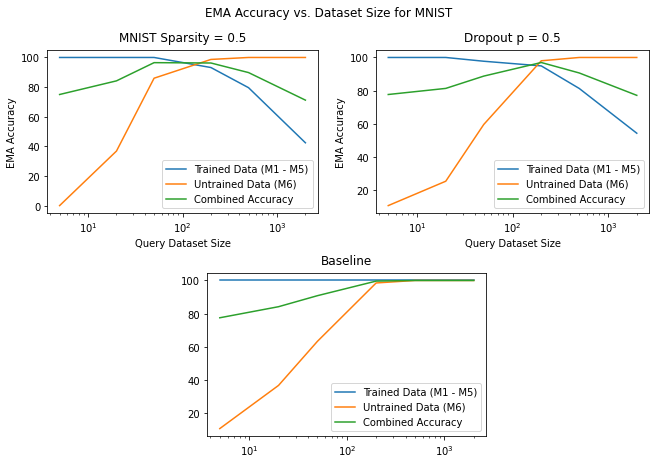

In [234]:
fig = plt.figure(figsize=(9, 6), layout="constrained")
spec = fig.add_gridspec(4, 4)

ax1 = fig.add_subplot(spec[:2, :2])
ax2 = fig.add_subplot(spec[:2, 2:])
ax3 = fig.add_subplot(spec[2:4, 1:3])

m6 = [100, 100, 98.67, 86, 36.83, 0]
m1 = [42.40, 79.6, 93.2, 100, 100, 100]
total = [71.2, 89.80000000000001, 96.26666666666667, 96.5, 84.20833333333334, 75.0]

drop_6 = [100, 100, 98, 59.67, 25.5, 10.83]
drop_1 = [54.4, 81.33, 94.93, 97.73, 100, 100]
drop_total = [77.2, 90.66666666666666, 96.96666666666667, 88.78333333333333, 81.375, 77.70833333333334]

base_total = [100.0, 100.0, 99.625, 90.83333333333333, 84.20833333333333, 77.54166666666667]
base_6 = [100, 100, 98.5, 63.33, 36.83, 10.83]
base_1 = [100, 100, 100, 100, 100, 100]

plt.suptitle("EMA Accuracy vs. Dataset Size for MNIST", y = 1.05)
ax1.plot(sizes, m1, label = "Trained Data (M1 - M5)")
ax1.plot(sizes, m6, label = "Untrained Data (M6)")
ax1.plot(sizes, total, label = "Combined Accuracy")

ax2.plot(sizes, drop_1, label = "Trained Data (M1 - M5)")
ax2.plot(sizes, drop_6, label = "Untrained Data (M6)")
ax2.plot(sizes, drop_total, label = "Combined Accuracy")

ax3.plot(sizes, base_1, label = "Trained Data (M1 - M5)")
ax3.plot(sizes, base_6, label = "Untrained Data (M6)")
ax3.plot(sizes, base_total, label = "Combined Accuracy")
ax3.legend()
ax3.set_title("Baseline", y=1.02)
ax3.set_xscale("log")

ax1.set_ylabel("EMA Accuracy")
ax1.set_xlabel("Query Dataset Size")
ax1.set_xscale("log")
ax1.legend()
ax2.set_ylabel("EMA Accuracy")
ax2.set_xlabel("Query Dataset Size")
ax2.set_xscale("log")
ax2.legend()
ax1.set_title("MNIST Sparsity = 0.5", y=1.02)
ax2.set_title("Dropout p = 0.5", y=1.02)
plt.show()

In [46]:
import matplotlib.pyplot as plt

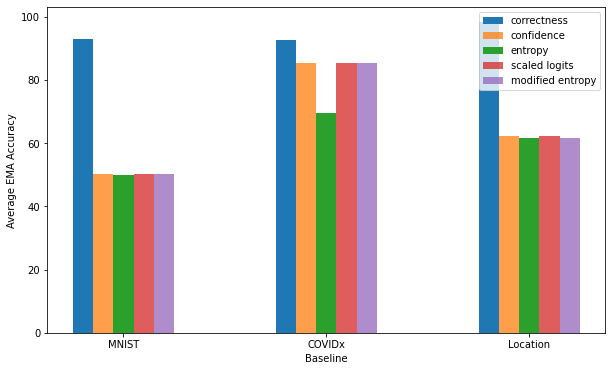

In [37]:
xs = ["MNIST", "COVIDx", "Location"]
confidence = [50.1, 85.41, 62.1]
correctness = [93.0, 92.58, 98.24]
entropy = [50.05, 69.67, 61.45]
scaled_logits = [50.1, 85.41, 62.1]
modified_entropy = [50.17, 85.41, 61.72]

ind = np.arange(3)  # the x locations for the groups
width = 0.1 

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.bar(ind, correctness, width, label="correctness")
overlapping = 0.750
ax.bar(ind+width, confidence,width,  label="confidence", alpha=overlapping)
ax.bar(ind + 2*width, entropy,width,  label="entropy")
ax.bar(ind + 3*width, scaled_logits,width,  label="scaled logits", alpha=overlapping)
ax.bar(ind + 4*width, modified_entropy,width,  label="modified entropy", alpha=overlapping)
ax.legend()


plt.xticks(ind + width * 2)
ax.set_xticklabels( xs)

plt.xlabel("Baseline")
plt.ylabel("Average EMA Accuracy")
plt.show()

In [295]:
ema_accuracy(mnist_dropout, weights=[50, 25, 25], detailed=False)
ema_accuracy(location_dropout, weights=[50,50], detailed=False)
ema_accuracy(covid_dropout, weights=[50,25,25], detailed=False)

MNIST_base_50: 92.03472222222221
MNIST_base_50 M6: 68.24999999999999
dropout0.1_redo: 91.0263888888889
dropout0.1_redo M6: 68.63888888888889
dropout0.2_redo: 91.8875
dropout0.2_redo M6: 72.08333333333334
dropout0.3_redo: 91.14305555555556
dropout0.3_redo M6: 69.86111111111111
dropout0.4_redo: 91.125
dropout0.4_redo M6: 64.61111111111111
dropout0.5_redo: 85.45
dropout0.5_redo M6: 65.66666666666667
dropout0.6_redo: 74.28750000000001
dropout0.6_redo M6: 68.47222222222221
dropout0.7_redo: 71.77361111111111
dropout0.7_redo M6: 75.47222222222223
dropout0.8_redo: 63.20000000000001
dropout0.8_redo M6: 78.72222222222223
dropout0.9_redo: 56.052777777777784
dropout0.9_redo M6: 83.11111111111111
[92.03472222222221, 91.0263888888889, 91.8875, 91.14305555555556, 91.125, 85.45, 74.28750000000001, 71.77361111111111, 63.20000000000001, 56.052777777777784]
Location_base_redo: 98.2361111111111
Location_base_redo M6: 96.47222222222223
LocDropout0.1_redo: 98.04166666666667
LocDropout0.1_redo M6: 96.0833333

In [296]:
ema_accuracy(mnist_pruning, weights=[50, 25, 25], detailed=False)
ema_accuracy(location_pruning, weights=[50,50], detailed=False)
ema_accuracy(covid_pruning, weights=[50,25,25], detailed=False)

MNIST_base_50: 92.03472222222221
MNIST_base_50 M6: 68.24999999999999
MNIST_sparsity0.1_redo: 85.62638888888888
MNIST_sparsity0.1_redo M6: 63.97222222222221
MNIST_sparsity0.2_redo: 83.54722222222222
MNIST_sparsity0.2_redo M6: 64.49999999999999
MNIST_sparsity0.3_redo: 86.91527777777777
MNIST_sparsity0.3_redo M6: 70.74999999999999
MNIST_sparsity0.4_redo: 84.6111111111111
MNIST_sparsity0.4_redo M6: 63.11111111111111
MNIST_sparsity0.5_redo: 85.49583333333334
MNIST_sparsity0.5_redo M6: 70.25
MNIST_sparsity0.625_redo: 82.41666666666667
MNIST_sparsity0.625_redo M6: 61.5
MNIST_sparsity0.65_redo: 84.6875
MNIST_sparsity0.65_redo M6: 60.97222222222222
MNIST_sparsity0.675_redo: 87.45555555555556
MNIST_sparsity0.675_redo M6: 77.44444444444444
MNIST_sparsity0.6_redo: 85.83611111111111
MNIST_sparsity0.6_redo M6: 67.83333333333333
MNIST_sparsity0.7_redo: 84.89722222222223
MNIST_sparsity0.7_redo M6: 64.83333333333333
MNIST_sparsity0.8_redo: 87.0
MNIST_sparsity0.8_redo M6: 74.22222222222221
MNIST_sparsit

In [303]:
covid_ema_prune = np.array([92.125, 93.9375, 69.28472222222223, 62.7125, 52.62083333333333, 50.45694444444444, 50.03055555555556, 50.46944444444444, 50.6625, 54.43472222222223])
location_ema_prune = np.array([98.2361111111111, 97.8611111111111, 97.36111111111113, 97.98611111111113, 98.43055555555554, 98.25, 98.47222222222221, 98.47222222222221, 99.15277777777777, 98.875, 99.7361111111111, 87.5138888888889, 64.17500000000001, 50.01111111111111])
mnist_ema_prune = np.array([92.03472222222221, 85.62638888888888, 83.54722222222222, 86.91527777777777, 84.6111111111111, 85.49583333333334, 82.41666666666667, 84.6875, 87.45555555555556, 85.83611111111111, 84.89722222222223, 87.0, 86.26805555555553])

covid_acc_prune = np.array([86.5, 85.1, 84.0, 82.0, 82.1, 74.2, 64.3, 59.8, 59.8, 59.8])
mnist_acc_prune = np.array([97.0, 97.0,97.0,97.0,97.0,96.9, 96.7, 96.5, 96.2, 95.9, 95.2, 77.0, 16.4])
location_acc_prune = np.array([48.1, 48.1, 48.1, 48.1, 47.3, 46.4, 46.2, 43.7, 43.0, 41.0, 38.5, 37.2, 32.5, 5.0])

covid_prune_emacost = covid_ema_prune[0] - covid_ema_prune
mnist_prune_emacost = mnist_ema_prune[0] - mnist_ema_prune
location_prune_emacost = location_ema_prune[0] - location_ema_prune

mnist_prune_acccost = mnist_acc_prune[0] - mnist_acc_prune
location_prune_accost = location_acc_prune[0] - location_acc_prune
covid_prune_accost = covid_acc_prune[0] - covid_acc_prune

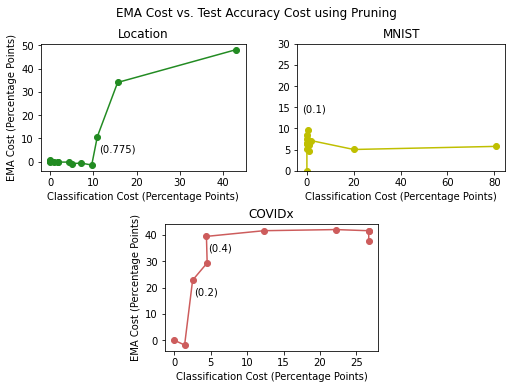

In [336]:
fig = plt.figure(figsize=(7, 5), layout="constrained")
spec = fig.add_gridspec(4, 4)

ax3 = fig.add_subplot(spec[:2, :2])
ax2 = fig.add_subplot(spec[:2, 2:])
ax1 = fig.add_subplot(spec[2:4, 1:3])


fig.suptitle('EMA Cost vs. Test Accuracy Cost using Pruning', y=1.05)
ax1.set_xlabel("Classification Cost (Percentage Points)")
ax2.set_xlabel("Classification Cost (Percentage Points)")
ax3.set_xlabel("Classification Cost (Percentage Points)")
ax1.set_ylabel("EMA Cost (Percentage Points)")
ax3.set_ylabel("EMA Cost (Percentage Points)")
ax1.set_title("COVIDx")
ax2.set_title("MNIST")
ax2.set_ylim(0, 30)
ax3.set_title("Location")
ax1.plot(covid_prune_accost, covid_prune_emacost, marker='o', color='indianred')
ax2.plot(mnist_prune_acccost, mnist_prune_emacost, marker='o', color='y')
ax3.plot(location_prune_accost, location_prune_emacost, marker='o', color='forestgreen')
ax3.annotate("(0.775)", (location_prune_accost[11], location_prune_emacost[11]), textcoords="offset points", xytext=(2, -15))
ax1.annotate("(0.2)", (covid_prune_accost[2], covid_prune_emacost[2]), textcoords="offset points", xytext=(2, -15))
ax2.annotate("(0.1)", (mnist_prune_acccost[1], mnist_prune_emacost[1]), textcoords="offset points", xytext=(-5, 32))
ax1.annotate("(0.4)", (covid_prune_accost[4], covid_prune_emacost[4]), textcoords="offset points", xytext=(2, -15))
plt.show()

In [236]:
ema_accuracy(tables, weights=[50,25,25], detailed=True)

MNIST_base_50 2000 100.0
MNIST_base_50 500 100.0
MNIST_base_50 200 99.625
MNIST_base_50 50 90.83333333333333
MNIST_base_50 20 84.20833333333333
MNIST_base_50 5 77.54166666666667
plateau10_redo 2000 100.0
plateau10_redo 500 100.0
plateau10_redo 200 99.16666666666667
plateau10_redo 50 89.83333333333333
plateau10_redo 20 80.66666666666666
plateau10_redo 5 75.0
plateau1_redo 2000 100.0
plateau1_redo 500 100.0
plateau1_redo 200 99.70833333333333
plateau1_redo 50 89.91666666666667
plateau1_redo 20 82.41666666666666
plateau1_redo 5 77.54166666666667
plateau20_redo 2000 100.0
plateau20_redo 500 100.0
plateau20_redo 200 99.625
plateau20_redo 50 92.0
plateau20_redo 20 80.66666666666666
plateau20_redo 5 77.70833333333334
plateau5_redo 2000 100.0
plateau5_redo 500 100.0
plateau5_redo 200 98.54166666666667
plateau5_redo 50 88.0
plateau5_redo 20 83.5
plateau5_redo 5 75.0
MNIST_base_50: 92.03472222222221
MNIST_base_50 M6: 17.062499999999996
plateau10_redo: 90.77777777777777
plateau10_redo M6: 15.7777

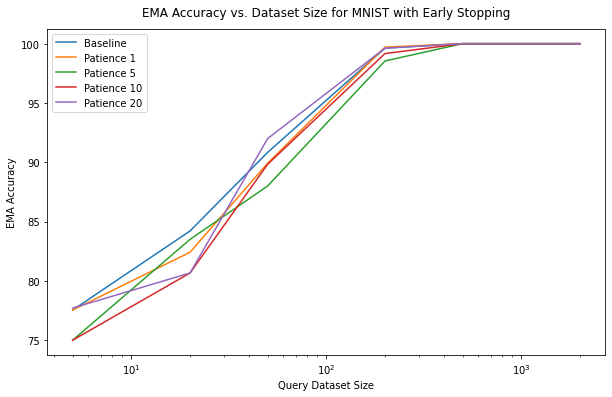

In [247]:
plateau = [0, 1, 5, 10, 20]
sizes = [2000, 500, 200, 50, 20, 5]
acc = [100.0, 100.0, 99.625, 90.83333333333333, 84.20833333333333, 77.54166666666667, 100.0, 100.0, 99.16666666666667, 89.83333333333333, 80.66666666666666, 75.0, 100.0, 100.0, 99.70833333333333, 89.91666666666667, 82.41666666666666, 77.54166666666667, 100.0, 100.0, 99.625, 92.0, 80.66666666666666, 77.70833333333334, 100.0, 100.0, 98.54166666666667, 88.0, 83.5, 75.0]

plt.figure(figsize=(10, 6))
plt.plot(sizes, acc[0:6], label = "Baseline")
plt.plot(sizes, acc[12:18], label = "Patience 1")
plt.plot(sizes, acc[24:30], label = "Patience 5")
plt.plot(sizes, acc[6:12], label = "Patience 10")
plt.plot(sizes, acc[18:24], label = "Patience 20")
plt.ylabel("EMA Accuracy")
plt.xlabel("Query Dataset Size")
plt.xscale("log")
plt.legend()
plt.title("EMA Accuracy vs. Dataset Size for MNIST with Early Stopping", y=1.02)
plt.show()

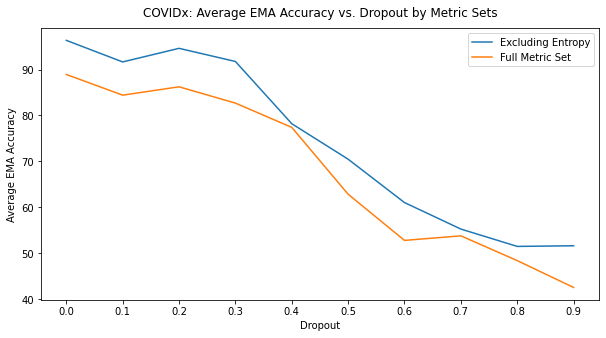

In [257]:
drop = np.arange(0, 1, 0.1)
entropy = [88.94, 84.43, 86.25, 82.7, 77.41, 62.85, 52.79, 53.78, 48.39, 42.54]
no_entropy = [96.37, 91.67, 94.63, 91.77, 78.21, 70.48, 61.03, 55.26, 51.48, 51.62]
plt.figure(figsize=(10, 5))
plt.plot(drop, no_entropy, label = "Excluding Entropy")
plt.plot(drop, entropy, label = "Full Metric Set")
plt.ylabel("Average EMA Accuracy")
plt.xlabel("Dropout")
plt.xticks(drop)
plt.legend()
plt.title("COVIDx: Average EMA Accuracy vs. Dropout by Metric Sets", y=1.02)
plt.show()

In [260]:
codrop_ema = np.array([92.125, 84.42916666666667, 86.25, 82.7, 77.40694444444445, 62.84583333333333, 52.794444444444444, 53.77638888888888, 48.39305555555555, 42.538888888888884])
codrop_ema2 = np.array(no_entropy)
locdrop_ema = np.array([98.2361111111111, 98.04166666666667, 97.65277777777779, 98.43055555555554, 99.33333333333333, 98.93055555555556, 99.09722222222223, 98.65277777777779, 55.49722222222223, 53.56666666666666])
mnistdrop_ema = np.array([92.03472222222221, 91.0263888888889, 91.8875, 91.14305555555556, 91.125, 85.45, 74.28750000000001, 71.77361111111111, 63.20000000000001, 56.052777777777784])

codrop_acc = np.array([86.50, 85.70, 89.10, 88.20, 87.10, 88.00, 87.10, 87.40, 87.50, 87.00])
mnistdrop_acc = np.array([96.24, 96.33, 96.40, 96.36, 96.16, 95.92, 95.35, 94.61, 93.10, 84.36])
locdrop_acc = np.array([48.00, 47.10, 49.18, 49.85, 48.73, 50.80, 50.93, 50.08, 31.50, 6.73])

co_perturb = codrop_ema[0] - codrop_ema
co_perturb2 = codrop_ema2[0] - codrop_ema2
mni_perturb = mnistdrop_ema[0] - mnistdrop_ema
loc_perturb = locdrop_ema[0] - locdrop_ema

mni_acc_perturb = mnistdrop_acc[0] - mnistdrop_acc
loc_acc_perturb = locdrop_acc[0] - locdrop_acc
co_acc_perturb = codrop_acc[0] - codrop_acc

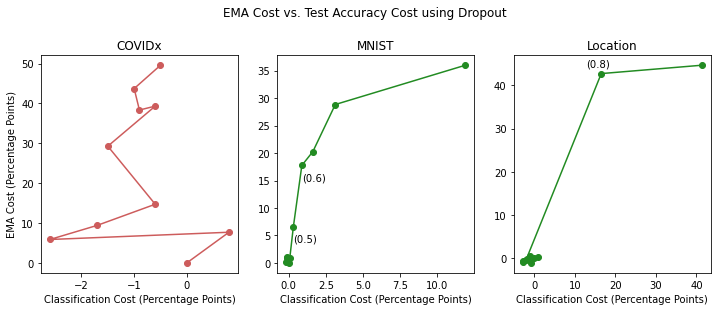

In [300]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle('EMA Cost vs. Test Accuracy Cost using Dropout', y=1.05)
ax1.set_xlabel("Classification Cost (Percentage Points)")
ax2.set_xlabel("Classification Cost (Percentage Points)")
ax3.set_xlabel("Classification Cost (Percentage Points)")
ax1.set_ylabel("EMA Cost (Percentage Points)")
ax1.set_title("COVIDx")
ax2.set_title("MNIST")
ax3.set_title("Location")
ax1.plot(co_acc_perturb, co_perturb, marker='o', color='indianred')
ax2.plot(mni_acc_perturb, mni_perturb, marker='o', color='forestgreen')
ax3.plot(loc_acc_perturb, loc_perturb, marker='o', color='forestgreen')
ax3.annotate("(0.8)", (loc_acc_perturb[8], loc_perturb[8]), textcoords="offset points", xytext=(-15, 7))
ax2.annotate("(0.6)", (mni_acc_perturb[6], mni_perturb[6]), textcoords="offset points", xytext=(0, -15))
ax2.annotate("(0.5)", (mni_acc_perturb[5], mni_perturb[5]), textcoords="offset points", xytext=(0, -15))
plt.show()

In [264]:
covid_reg = compute_tables(covid_base, ['COVIDx'], sizes, ['t'], 50, metrics, klist, mixup)
mnist_reg = compute_tables(mnist_base, ['MNIST'], sizes, ['t'], 50, metrics, klist, mixup)
location_reg = compute_tables(location_base, ['Location'], sizes, ['t'], 200, metrics, klist, mixup)
covid_ks = compute_tables(covid_base, ['COVIDx'], sizes, ['ks'], 50, metrics, klist, mixup)
mnist_ks = compute_tables(mnist_base, ['MNIST'], sizes, ['ks'], 50, metrics, klist, mixup)
location_ks = compute_tables(location_base, ['Location'], sizes, ['ks'], 200, metrics, klist, mixup)
covid_epps = compute_tables(covid_base, ['COVIDx'], sizes, ['epps'], 50, metrics, klist, mixup)
mnist_epps = compute_tables(mnist_base, ['MNIST'], sizes, ['epps'], 50, metrics, klist, mixup)
location_epps = compute_tables(location_base, ['Location'], sizes, ['epps'], 200, metrics, klist, mixup)

ema_accuracy(covid_ks, weights=[50, 25, 25], metrics=False)
ema_accuracy(covid_reg, weights=[50, 25, 25], metrics=False)
ema_accuracy(covid_epps, weights=[50, 25, 25], metrics=False)
ema_accuracy(mnist_ks, weights=[50, 25, 25], metrics=False)
ema_accuracy(mnist_reg, weights=[50, 25, 25], metrics=False)
ema_accuracy(mnist_epps, weights=[50, 25, 25], metrics=False)
ema_accuracy(location_ks, weights=[50, 50, 25], metrics=False)
ema_accuracy(location_reg, weights=[50, 50, 25], metrics=False)
ema_accuracy(location_epps, weights=[50, 50, 25], metrics=False)

-----  Query_size:2000 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5   C6 Chest
k=100  1  1  1  1  1  0.0   0.0
k=90   1  1  1  1  1  0.0   0.0
k=80   1  1  1  1  1  0.0   0.0
k=70   1  1  1  1  1  0.0   0.0
k=60   1  1  1  1  1  0.0   0.0
k=50   1  1  1  1  1  0.0   0.0 

-----  Query_size:500 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5   C6 Chest
k=100  1  1  1  1  1  0.0   0.0
k=90   1  1  1  1  1  0.0   0.0
k=80   1  1  1  1  1  0.0   0.0
k=70   1  1  1  1  1  0.0   0.0
k=60   1  1  1  1  1  0.0   0.0
k=50   1  1  1  1  1  0.0   0.0 

-----  Query_size:200 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5   C6 Chest
k=100  1  1  1  1  1  0.0   0.0
k=90   1  1  1  1  1  0.0   0.0
k=80   1  1  1  1  1  0.0   0.0
k=70   1  1  1  1  1  0.0   0.0
k=60   1  1  1  1  1  0.0   0.0
k=50   1  1  1  1  1  0.0   0.0 

-----  Query_size:50 	 Cal data:COVIDx  -----
      C1 C2 C3 C4 C5    C6 Chest
k=100  1  1  1  1  1  0.01   0.0
k=90   1  1  1  1  1  0.01   0.0
k=80   1  1  1  1  1  0.08  0.01
k=

        M1   M2   M3   M4   M5    M6  SVHN
k=100  1.0  1.0  1.0  1.0  1.0  0.96   0.0
k=90   1.0  1.0  1.0  1.0  1.0   1.0   0.0
k=80   1.0  1.0  1.0  1.0  1.0   1.0   0.0
k=70   1.0  1.0  1.0  1.0  1.0   1.0   0.0
k=60   1.0  1.0  1.0  1.0  1.0   1.0  0.03
k=50   1.0  1.0  1.0  1.0  1.0   1.0   0.0 

-----  Query_size:2000 	 Cal data:Location  -----
        L1   L2   L3   L4   L5   L6
k=100  1.0  1.0  1.0  1.0  1.0  0.0
k=90   1.0  1.0  1.0  1.0  1.0  0.0
k=80   1.0  1.0  1.0  1.0  1.0  0.0
k=70   1.0  1.0  1.0  1.0  1.0  0.0
k=60   1.0  1.0  1.0  1.0  1.0  0.0
k=50   1.0  1.0  1.0  1.0  1.0  0.0 

-----  Query_size:500 	 Cal data:Location  -----
        L1   L2   L3   L4   L5   L6
k=100  1.0  1.0  1.0  1.0  1.0  0.0
k=90   1.0  1.0  1.0  1.0  1.0  0.0
k=80   1.0  1.0  1.0  1.0  1.0  0.0
k=70   1.0  1.0  1.0  1.0  1.0  0.0
k=60   1.0  1.0  1.0  1.0  1.0  0.0
k=50   1.0  1.0  1.0  1.0  1.0  0.0 

-----  Query_size:200 	 Cal data:Location  -----
        L1   L2   L3   L4   L5   L6
k=100

In [265]:
covid_ks = [99.45833333333333, 98.25, 96.25, 79.54166666666667, 64.33333333333333, 53.208333333333336]
covid_reg = [100.0, 100.0, 100.0, 99.16666666666667, 94.58333333333333, 59.0]
covid_web = [100.0, 100.0, 100.0, 99.16666666666667, 94.20833333333333, 58.66666666666667]
mnist_ks = [97.58333333333333, 83.70833333333334, 86.41666666666666, 75.04166666666666, 75.08333333333334, 75.04166666666666]
mnist_reg = [100.0, 100.0, 99.625, 90.83333333333333, 84.20833333333333, 77.54166666666667]
mnist_web = [100.0, 100.0, 99.58333333333333, 90.83333333333333, 84.08333333333333, 77.25]
location_ks = [100.0, 100.0, 100.0, 100.0, 99.91666666666666, 72.91666666666667]
location_reg = [100.0, 100.0, 100.0, 100.0, 100.0, 89.41666666666666]
location_web = [100.0, 100.0, 100.0, 100.0, 100.0, 88.08333333333333]

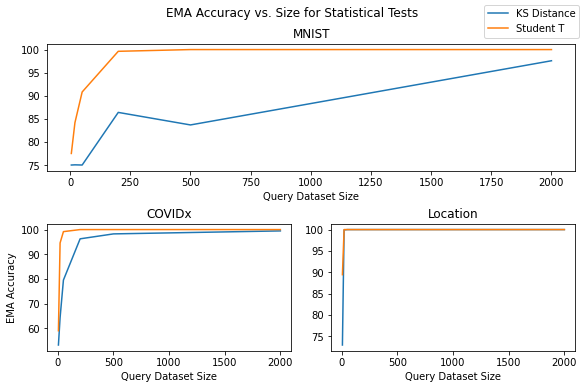

In [276]:
fig = plt.figure(figsize=(7, 5), layout="constrained")
spec = fig.add_gridspec(2, 2)

ax2 = fig.add_subplot(spec[0, :])
ax1 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[1, 1])

ax4.axis("off")
fig.suptitle('EMA Accuracy vs. Size for Statistical Tests', y=1.05)
ax1.plot(sizes, covid_ks, label="KS Distance")
ax1.plot(sizes, covid_reg, label="Student T")
# ax1.plot(sizes, covid_web, label="Welch T")
ax1.set_xlabel("Query Dataset Size")
ax1.set_title("COVIDx")
ax2.set_title("MNIST")
ax3.set_title("Location")
ax2.set_xlabel("Query Dataset Size")
ax3.set_xlabel("Query Dataset Size")
ax1.set_ylabel("EMA Accuracy")
ax2.plot(sizes, mnist_ks)
ax2.plot(sizes, mnist_reg)
# ax2.plot(sizes, mnist_web)
ax3.plot(sizes, location_ks)
ax3.plot(sizes, location_reg)
# ax3.plot(sizes, location_web)
fig.legend()
plt.show()

In [20]:
ema_accuracy(covid_tables, weights=[50, 25, 25], metrics=True)

COVIDx_base['correctness']: 92.58333333333333
COVIDx_base['confidence']: 85.40833333333332
COVIDx_base['entropy']: 69.66527777777777
COVIDx_base['modified entropy']: 85.40833333333332
COVIDx_base['scaled logits']: 85.40833333333332
COVIDx_base['correctness', 'confidence', 'entropy', 'modified entropy', 'scaled logits']: 92.125
COVIDx_base['correctness', 'confidence']: 92.48611111111113
COVIDx_base['correctness', 'entropy']: 92.2361111111111
COVIDx_base['correctness', 'modified entropy']: 92.48611111111113
COVIDx_base['correctness', 'scaled logits']: 92.48611111111113
COVIDx_base['correctness', 'confidence', 'scaled logits', 'modified entropy']: 92.48611111111113


In [21]:
ema_accuracy(location_tables, weights=[50,50], metrics=True)

Location_base_redo['correctness']: 98.2361111111111
Location_base_redo['confidence']: 62.1
Location_base_redo['entropy']: 61.44722222222222
Location_base_redo['modified entropy']: 61.719444444444434
Location_base_redo['scaled logits']: 62.1
Location_base_redo['correctness', 'confidence', 'entropy', 'modified entropy', 'scaled logits']: 98.2361111111111
Location_base_redo['correctness', 'confidence']: 98.2361111111111
Location_base_redo['correctness', 'entropy']: 98.2361111111111
Location_base_redo['correctness', 'modified entropy']: 98.2361111111111
Location_base_redo['correctness', 'scaled logits']: 98.2361111111111
Location_base_redo['correctness', 'confidence', 'scaled logits', 'modified entropy']: 98.2361111111111


In [60]:
ema_accuracy(tables_plateau)

Control EMA 2000 100.0
Control EMA 500 100.0
Control EMA 200 98.22222222222223
Control EMA 50 84.44444444444444
Control EMA 20 70.44444444444444
Control EMA 5 66.66666666666667
re-plateau20 2000 100.0
re-plateau20 500 100.0
re-plateau20 200 99.11111111111113
re-plateau20 50 84.0
re-plateau20 20 78.94444444444444
re-plateau20 5 70.27777777777779
re-plateau10 2000 100.0
re-plateau10 500 100.0
re-plateau10 200 98.11111111111111
re-plateau10 50 81.77777777777777
re-plateau10 20 78.94444444444444
re-plateau10 5 74.83333333333333
re-plateau5 2000 100.0
re-plateau5 500 100.0
re-plateau5 200 98.11111111111111
re-plateau5 50 86.0
re-plateau5 20 78.94444444444444
re-plateau5 5 75.05555555555556
re-plateau1 2000 100.0
re-plateau1 500 100.0
re-plateau1 200 99.55555555555556
re-plateau1 50 92.44444444444446
re-plateau1 20 74.22222222222223
re-plateau1 5 70.27777777777779


In [25]:
def graph_200(tables, filter_size=200, NUM_COLORS=11, no_svhn=False):
    # three graphs (in, out, svhn) one line per experiment at size = 200 vs K
    fig = plt.figure()
    axes = []
    if not no_svhn:
        ax1 = plt.subplot(2, 2, (1, 2))
        ax2 = plt.subplot(2, 2, 3)
        ax3 = plt.subplot(2, 2, 4)
        axes = [ax1, ax2, ax3]
    else:
        ax1 = plt.subplot(1, 2, 1)
        ax2 = plt.subplot(1, 2, 2)
        axes = [ax1, ax2]
        
    filtered = filter(lambda table: table.size == filter_size, tables)
    fig.tight_layout(pad=2.0)
    fig.set_size_inches(12.5, 9.5)

    if NUM_COLORS > 10:
        cm = plt.get_cmap('plasma')
    else:
        cm = plt.get_cmap('hsv')
    
    fig.suptitle("EMA Performance for Query-size 200")
    ax1.set_xlabel("K")
    ax1.set_ylabel("Average P Value")
    ax1.set_title("In-Data P Value vs. K")
    ax1.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    
    ax2.set_xlabel("K")
    ax2.set_title("Out-Data P Value vs. K")
    ax2.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    
    if not no_svhn:
        ax3.set_title("SVHN P Value vs. K")
        ax3.set_xlabel("K")
        ax3.set_ylabel("P Value")
        ax3.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    
    for ax in axes:
        ax.set_yticks(np.arange(0, 1.01, 0.1))
        
    
    for size_table in filtered:
        table = size_table.table
        expt = size_table.expt
        if "re-dropout" in expt:
            expt_string = "Dropout " + expt.strip("re-dropout")
        elif "re-plateau" in expt:
            expt_string = "LR Plateau" + expt.strip("re-plateau")
        else:
            expt_string = expt
            
        ks = []
        ins = []
        outs = []
        svhns = []
        for index, row in table.iterrows():
            k_val = int(index.strip("k="))
            in_data = list(row[['M1', 'M2', 'M3', 'M4', 'M5']])
            out_data = row['M6']
            ks.append(k_val)
            ins.append(np.mean(in_data))
            outs.append(out_data)
            if not no_svhn:
                svhn = row['SVHN']
                svhns.append(svhn)
        ax1.plot(ks, ins, label=expt_string)
        ax2.plot(ks, outs, label=expt_string)
        if not no_svhn:
            ax3.plot(ks, svhns, label=expt_string)

    ax2.plot(np.arange(50, 101, 10), [0.1]*6, 'r--', label="threshold")

    lines = []
    labels = []

    Line, Label = ax2.get_legend_handles_labels()
    # print(Label)
    lines.extend(Line)
    labels.extend(Label)

    fig.legend(lines, labels, loc='center right')
    
    plt.savefig("Location_Dropout_200.png", format="png", dpi="figure")
    plt.show()
    plt.close()

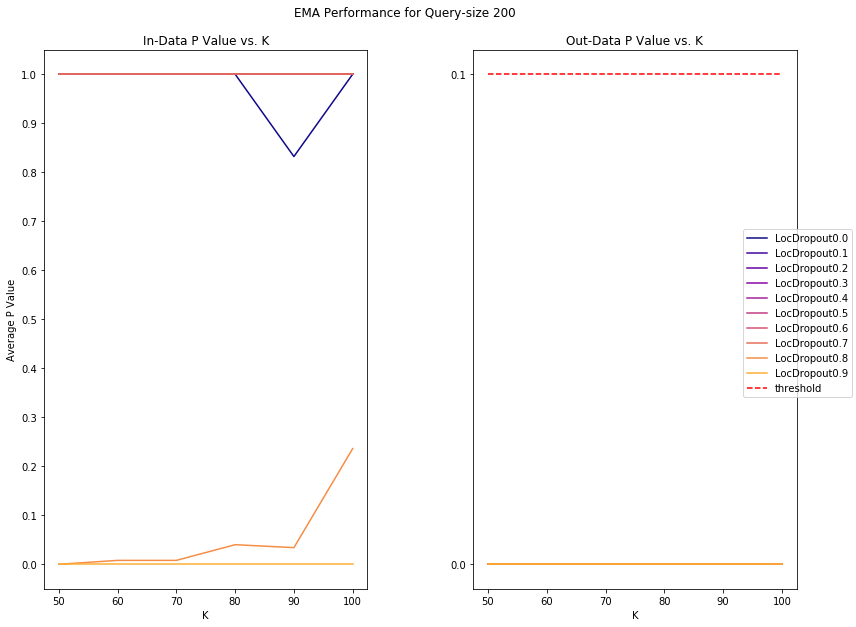

In [27]:
graph_200(tables, 200, 11, True)